## On the representation of USEC sea level in HRMIP models

In [1]:
%load_ext autoreload
%autoreload 2

# import intake
import numpy as np
import netCDF4 as nc
import xarray as xr
import os
from matplotlib import pyplot as plt
import xesmf as xe
import pandas as pd
import pickle
import cartopy.crs as ccrs
import cartopy.feature as cfeature
# import matplotlib.ticker as mticker
# from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from gfdl_grid_paper import *
import momlevel
import glob
import cf_xarray as cfxr

## Create Dask Cluster

In [2]:
import dask
from dask.distributed import wait
dask.__version__

'2024.1.1'

In [3]:
inputdir='/glade/work/clittle/p2521/input/'
inputdir2='/glade/work/clittle/p2521/'
modeldir='model/'
# ds_grid = xr.open_dataset(inputdir+modeldir+'ESM4_ocean_static.nc')
# ds_grid_esm4=ds_grid[['geolon','geolat','geolon_c','geolat_c','wet','areacello', 'deptho']]

In [4]:
tgcsvin = './tg_locs_gs.csv'
# temp

In [5]:
margin = 2

def cutdomain(ds, margin):
    # Common variations of latitude and longitude names
    latitude_names = ['lat', 'latitude', 'Latitude', 'LAT', 'nav_lat']
    longitude_names = ['lon', 'longitude', 'Longitude', 'LON', 'nav_lon']

    #latitude_names = ds.cf.coordinates['latitude'][0]
    #longitude_names = ds.cf.coordinates['longitude'][0]

    # Identify the latitude and longitude coordinate names in the dataset
    lat_name = next((name for name in latitude_names if name in ds.coords), None)
    lon_name = next((name for name in longitude_names if name in ds.coords), None)

    if lat_name is None or lon_name is None:
        raise ValueError("Latitude or longitude coordinate not found in the dataset.")
   
    # Ensure that latitude and longitude arrays are computed before using them for indexing
    ds[lat_name] = ds[lat_name].compute()
    ds[lon_name] = ds[lon_name].compute()

    # Apply the margin-based conditions using the detected latitude and longitude names
    ds = ds.where(ds[lat_name] < max_lat + margin, drop=True)
    ds = ds.where(ds[lat_name] > min_lat - margin, drop=True)
    ds = ds.where(ds[lon_name] < max_lon + margin, drop=True)
    ds = ds.where(ds[lon_name] > min_lon - margin, drop=True)

    return ds

In [6]:
def model_dim_check(ds):
    if 'j' not in list(ds.dims):
        ds = ds.rename({'y':'j', 'x':'i','lat':'latitude', 'lon':'longitude'})#.drop(#['lon']#=ds_grid.geolon.values
        
    if 'lat_bnds' in list(ds.keys()):
        ds = ds.rename({'lat_bnds':'vertices_latitude', 'lon_bnds':'vertices_longitude', 'vertex':'vertices'})#.drop(#['lon']#=ds_grid.geolon.values

    if 'bounds_lat' in list(ds.keys()):
        ds = ds.rename({'bounds_lat':'vertices_latitude', 'bounds_lon':'vertices_longitude', 'nvertex':'vertices'})#.drop(#['lon']#=ds_grid.geolon.values
        
    # Common variations of latitude and longitude names
    latitude_names = ['lat', 'latitude', 'Latitude', 'LAT', 'nav_lat']
    longitude_names = ['lon', 'longitude', 'Longitude', 'LON', 'nav_lon']

    #latitude_names = ds.cf.coordinates['latitude'][0]
    #longitude_names = ds.cf.coordinates['longitude'][0]

    # Identify the latitude and longitude coordinate names in the dataset
    lat_name = next((name for name in latitude_names if name in ds.coords), None)
    lon_name = next((name for name in longitude_names if name in ds.coords), None)
    
    if ds.sizes['i'] > ds.sizes['j']:
        print('i dimension is larger than j dimension. Therefore, dimension names need to be swapped')
        ds = ds.rename({'i':'i_temp', 'j':'j_temp'})
        ds = ds.rename({'i_temp':'j', 'j_temp':'i'})
        print('dimension names swapped')

    else:
        #ds.sizes['i'] < ds.sizes['j']
        print('no swapping of i and j dimensions')

    if ds[lon_name].min() < 0:
        print('longitude ranges from -180 to 180. This needs to be changed as 0 to 360')
        temp = ds[lon_name]
        temp = (temp+360)%360
        ds = ds.drop_vars('longitude')
        ds = ds.assign_coords(longitude=(['i', 'j'], temp.data))
        print('longitude values changed')

    return(ds)

## HISTORICAL/MEAN STATE
<!-- Li doesn't comment on rate or early appearance! -->

In [7]:
%%time
# Define available models
mods = [
    "DTU22",
    "HadGEM3-GC31-LL",  
    "HadGEM3-GC31-HM",
    "CNRM-CM6-1",       
    "CNRM-CM6-1-HR",    
    "ECMWF-IFS-LR",     
    "ECMWF-IFS-MR",     
    "EC-Earth3P",       
    "EC-Earth3P-HR"
    # "CMCC-CM2-HR4",
    # "CMCC-CM2-VHR4",
    # "HadGEM3-GC31-HH"
]
ds_models=[]
source_ids = mods#[4:6]
for i in range(len(source_ids)):
    source_id=source_ids[i]
    if (source_id=="DTU22"):
        ds_zos = xr.open_dataset("/glade/work/clittle/p2521/input/obs/dtuuh22mdt.nc")
    else:
        if (source_id=="GFDL-ESM4") or (source_id=="GFDL-CM4"):
            ds_zos = xr.open_mfdataset(inputdir2+'zos_Omon_'+source_id+'*.nc')
            ds_zos = ds_zos.rename({'y':'j', 'x':'i','lat':'latitude', 'lon':'longitude'})#.drop(#['lon']#=ds_grid.geolon.values
        else:
            filepath = f'/glade/work/netige/Data/CMIP6_Downloader/data/s_{source_id}_e_hist-1950_vl_r1i*_f_mon_v_zos/'
            ds_zos_flist1 = sorted(glob.glob(filepath+f'/zos_Omon_{source_id}_hist-1950_r1i*_gn_199*.nc'))
            ds_zos_flist2 = sorted(glob.glob(filepath+f'/zos_Omon_{source_id}_hist-1950_r1i*_gn_200*.nc'))#[0-9].nc'))
            ds_zos_flist3 = sorted(glob.glob(filepath+f'/zos_Omon_{source_id}_hist-1950_r1i*_gn_201*.nc'))
            ds_zos_flist = (ds_zos_flist1+ds_zos_flist2+ds_zos_flist3)
            ds_zos = xr.open_mfdataset(ds_zos_flist)        # print(i)
        
    # #Check if model dimensions are compatible to run cutdomain. If not modify model dimensions
        ds_zos = model_dim_check(ds_zos)
    
    # #Select region of interest IF regridding
    min_lon = 260
    max_lon = 320
    min_lat = 15
    max_lat = 60
    min_lon = 260
    max_lon = 360
    min_lat = 15
    max_lat = 75
    # max_lat = 20
    ds_zos= cutdomain(ds_zos, margin)

    if (source_id=="DTU22"):
        ds_model = ds_zos.rename({'mdt':'zos'}).drop_vars('err_mdt')
    else:
        ds_model = ds_zos.groupby("time.year").mean().sel(year=slice('1993','2012'))
        ds_model=ds_model.mean(dim='year').compute()   
    ds_models.append(ds_model)
    print('Done with ' + source_ids[i])
# ds_models

Done with DTU22
i dimension is larger than j dimension. Therefore, dimension names need to be swapped
dimension names swapped
longitude ranges from -180 to 180. This needs to be changed as 0 to 360
longitude values changed
Done with HadGEM3-GC31-LL
i dimension is larger than j dimension. Therefore, dimension names need to be swapped
dimension names swapped
longitude ranges from -180 to 180. This needs to be changed as 0 to 360
longitude values changed
Done with HadGEM3-GC31-HM
i dimension is larger than j dimension. Therefore, dimension names need to be swapped
dimension names swapped
longitude ranges from -180 to 180. This needs to be changed as 0 to 360
longitude values changed
Done with CNRM-CM6-1
i dimension is larger than j dimension. Therefore, dimension names need to be swapped
dimension names swapped
longitude ranges from -180 to 180. This needs to be changed as 0 to 360
longitude values changed


/glade/u/home/netige/miniconda3/envs/_MDTF_python3_base/lib/python3.12/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/glade/u/home/netige/miniconda3/envs/_MDTF_python3_base/lib/python3.12/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ... 

Done with CNRM-CM6-1-HR
no swapping of i and j dimensions
Done with ECMWF-IFS-LR
no swapping of i and j dimensions
Done with ECMWF-IFS-MR
i dimension is larger than j dimension. Therefore, dimension names need to be swapped
dimension names swapped
Done with EC-Earth3P
i dimension is larger than j dimension. Therefore, dimension names need to be swapped
dimension names swapped
Done with EC-Earth3P-HR
CPU times: user 1min 48s, sys: 12.3 s, total: 2min
Wall time: 2min 49s


In [8]:
lrlist=[1,3,5,7,10]
lrsource=np.array([0,1,0,1,0,1,0,1,0,0,1,0,0])
posmat=np.array([[0,0,1,0,1,0,1,0,1,2,0,1,2],[0,1,1,2,2,3,3,4,4,4,5,5,5]])
# len(source_ids)
# obslist=[0]
# hrlist=list(range(len(source_ids)))
# hrlist = [index for index in hrlist if index not in (obslist+lrlist)]

In [9]:
posmat[0,0]

0

In [10]:
# %%time
models_mdt=[]
models_mdt_rel_tgs=[]
tgs_coast=[]
asdiff=np.nan*np.arange(len(source_ids))
csdiff=np.nan*np.arange(len(source_ids))
# crossdiff=[]

tgind1 = 4
tgind2 = 7
tgind3 = 11
tgind = tgind1

for i in range(len(source_ids)):
    ds_model=ds_models[i]
    temp=ds_model.zos
    
    omask=xr.where(np.isnan(temp), np.nan, 1)
    tgs_temp=momlevel.extract_tidegauge(temp, temp.longitude, temp.latitude, mask=omask, csv=tgcsvin)
    model_mdt_rel_tg = (temp-tgs_temp[tgind].values) #Relative to a tide gauge location
    print(tgs_temp[tgind].values)
    model_mdt = (temp) #NOT relative to a tide gauge location
    asdiff[i] = (tgs_temp[tgind2].values-tgs_temp[tgind1].values)
    csdiff[i] = (tgs_temp[tgind1].values-tgs_temp[tgind3].values) 
    models_mdt.append(model_mdt.compute())
    models_mdt_rel_tgs.append(model_mdt_rel_tg.compute())
    tg_coast = (tgs_temp-tgs_temp[tgind].values) #2nd TG from N
    tgs_coast.append(tg_coast.to_array().values)
tgs_coast=np.stack(tgs_coast)
# print('Done with ' + source_ids[i])

/glade/u/home/netige/miniconda3/envs/_MDTF_python3_base/lib/python3.12/site-packages/momlevel/util.py:555: UserWarning: Constructing coordinates from 1-D vectors. Make sure this is the intended behavior. Do not use `xh`/`yh` when `geolon`/`geolat` are available
  warnings.warn(


-0.034
-0.61119384
-0.5758554
-0.6071747
-0.49823546
-0.5304232
-0.5246022
-0.68403584
-0.5198037


### NOT relative to tide gauge -- relative to model geoid

In [12]:
ds_models[8].zos

<xarray.DataArray 'zos' (i: 469, j: 417)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * i          (i) int32 581 582 583 584 585 586 ... 1045 1046 1047 1048 1050
  * j          (j) int32 383 384 385 386 387 388 ... 1145 1146 1147 1148 1149
    latitude   (i, j) float32 13.13 13.13 13.13 13.13 ... 80.61 80.5 80.38 80.27
    longitude  (i, j) float32 168.2 168.5 168.8 169.0 ... 73.62 73.61 73.61

In [13]:
ds_bathy = xr.open_dataset(inputdir+"/obs/GEBCO.nc")
ds_bathy= cutdomain(ds_bathy, margin)

In [14]:
print(ds_bathy)

<xarray.Dataset>
Dimensions:    (latitude: 768, longitude: 1224)
Coordinates:
  * latitude   (latitude) float64 13.08 13.17 13.25 13.33 ... 76.83 76.92 77.0
  * longitude  (longitude) float64 258.0 258.1 258.2 258.3 ... 359.8 359.8 359.9
Data variables:
    depth      (latitude, longitude) float64 -3.151e+03 -3.14e+03 ... -3.181e+03
Attributes:
    description:  GEBCO bathymetry (depth below geoid) data


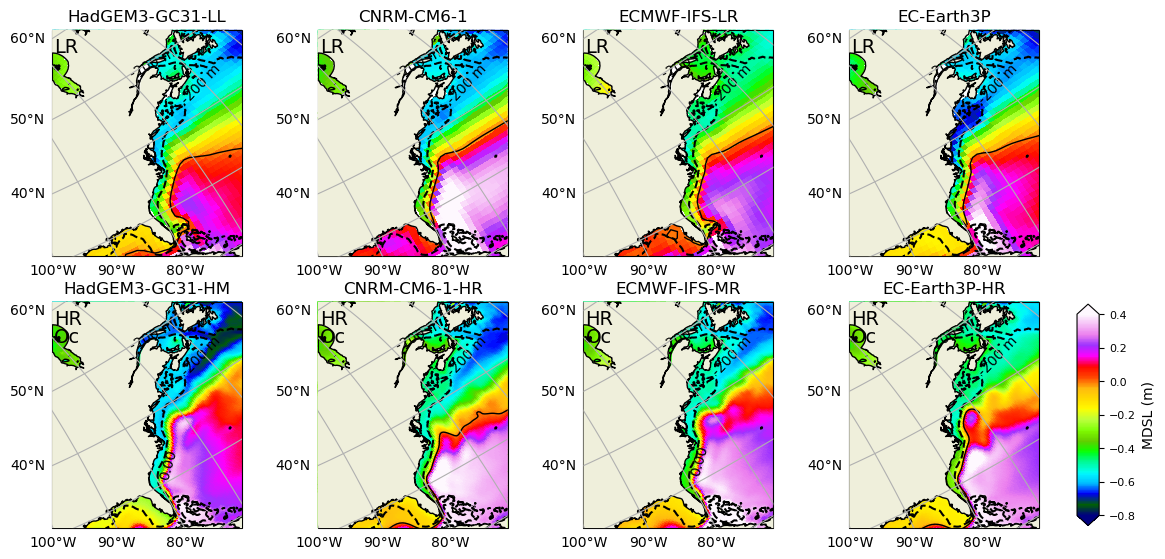

In [19]:
# %%time
import warnings
warnings.filterwarnings( "ignore")#cell edges

pc = []
axes = []
fig = plt.figure(figsize=(20, 10))
vmin = -0.8
vmax = .4
rotated_crs = ccrs.RotatedPole(pole_longitude=30, 
                                       pole_latitude=60)
for i in np.arange(1,len(source_ids),1):
    plotdata = models_mdt[i]

    ax = plt.subplot2grid((3,6), (posmat[0,i],posmat[1,i]), colspan=1, rowspan=1, projection=rotated_crs)#, aspect="auto")
    pos = ax.get_position() # get the original position 
    p=plt.pcolormesh(plotdata.longitude ,plotdata.latitude, plotdata,
                     vmin=vmin, vmax=vmax, 
                      #cmap='RdBu_r',
                     cmap='gist_ncar',
                     # cmap='Spectral_r',
                     zorder=1,
                     # shading='flat',
                     transform=ccrs.PlateCarree())
    # CS2 = ax.contour(plotdata.longitude ,plotdata.latitude, plotdata,
    #                 np.arange(vmin,0,vmax),colors='k',linewidths=2,zorder=2,transform=ccrs.PlateCarree())
    CS2 = ax.contour(plotdata.longitude ,plotdata.latitude, plotdata,
                    np.arange(vmin,vmax*2,-vmin),colors='k',linewidths=1,zorder=2,transform=ccrs.PlateCarree())
    ax.clabel(CS2, CS2.levels, inline=True, colors='k',fontsize=10,fmt='%1.2f')

    ax.set_extent([-71,-75,20,60], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND.with_scale('110m'),zorder=4)
    ax.add_feature(cfeature.COASTLINE, edgecolor="black",zorder=4) 
    #ax.add_feature(cfeature.STATES, edgecolor="black",zorder=4) 
    # ax.scatter(tgs_temp[tgind].real_coords[1], tgs_temp[tgind].real_coords[0], s=200, marker='*', color='k', zorder=7, transform=ccrs.PlateCarree())
    # ax.scatter(tgs_temp[tgind2].real_coords[1], tgs_temp[tgind2].real_coords[0], s=100, marker='*', color='k', zorder=5, transform=ccrs.PlateCarree())
    # ax.scatter(tgs_temp[tgind3].real_coords[1], tgs_temp[tgind3].real_coords[0], s=100, marker='*', color='k', zorder=5, transform=ccrs.PlateCarree())
    # ax.text(.01,.95, source_ids[i], transform=ax.transAxes, fontsize=12,zorder=6)
    ax.set_title(source_ids[i],loc='center')

    if i<1:
        ax.text(.01,.90, 'OBS', transform=ax.transAxes, fontsize=14,zorder=6)
    else:
        if posmat[0,i]<1:
            ax.text(.01,.90, 'LR', transform=ax.transAxes, fontsize=14,zorder=6)
        else:
            if posmat[0,i]<2:
                ax.text(.01,.90, 'HR', transform=ax.transAxes, fontsize=14,zorder=6)
                ax.text(.01,.82, 'Oc', transform=ax.transAxes, fontsize=14,zorder=6)
            else:
                ax.text(.01,.82, 'Oc+Atm', transform=ax.transAxes, fontsize=14,zorder=6)
                ax.text(.01,.90, 'HR', transform=ax.transAxes, fontsize=14,zorder=6)

    # Plot 200m bathymetry contour line
    CS_bathy = ax.contour(ds_bathy.longitude, ds_bathy.latitude, ds_bathy.depth, 
                          levels=[-200],  # Bathymetry depth contour at 200m
                          colors='black',  # Choose contour color
                          linewidths=1.5, 
                          zorder=3, 
                          transform=ccrs.PlateCarree())

# Label the contour line
    ax.clabel(CS_bathy, CS_bathy.levels, inline=True, fontsize=10, fmt='%d m')
        
    # ax.text(.01,.9, bias[i], transform=ax.transAxes, fontsize=10,zorder=6)
    # axes.append(ax)
    # print('Done with ' + source_ids[i])
    gl = ax.gridlines(draw_labels=False, dms=True, x_inline=False, y_inline=False,zorder=6)
    #if nsp<1:
    gl.ylabels_left = True
    #if nreg>(len(reginfo)-2): 
    gl.xlabels_bottom = True
# right_row_pc = [pc[1], pc[3]]
cbar_ax = fig.add_axes(
    [pos.x1+(pos.x1 - pos.x0) / 10, pos.y0, (pos.x1 - pos.x0)/10, (pos.y1 - pos.y0)]
)
cbar = fig.colorbar(p, orientation="vertical", cax=cbar_ax, extend="both",ticklocation='right')
# cbar.ax.set_title("EOF" + str(nsp+1), rotation=0, size=10, weight="bold")
cbar.ax.tick_params(labelsize=8)
# cbar = fig.colorbar(pc[0], ax=axes, orientation='vertical', fraction=0.03, pad=0.1)
cbar.set_label('MDSL (m)')  # Example label, adjust as needed

# #plt.tight_layout()
# plt.show()
plt.savefig('p1_f1.png',
)

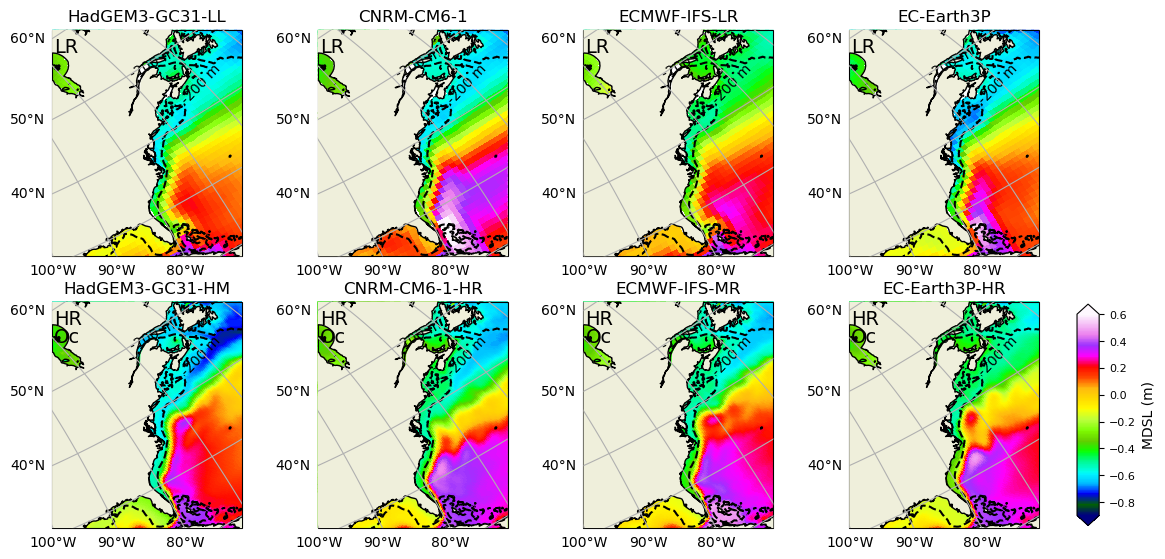

In [16]:
# %%time
import warnings
warnings.filterwarnings( "ignore")#cell edges

pc = []
axes = []
fig = plt.figure(figsize=(20, 10))
vmin = -0.9
vmax = 0.6
rotated_crs = ccrs.RotatedPole(pole_longitude=30, 
                                       pole_latitude=60)
for i in np.arange(1,len(source_ids),1):
    plotdata = models_mdt[i]

    ax = plt.subplot2grid((3,6), (posmat[0,i],posmat[1,i]), colspan=1, rowspan=1, projection=rotated_crs)#, aspect="auto")
    pos = ax.get_position() # get the original position 
    p=plt.pcolormesh(plotdata.longitude ,plotdata.latitude, plotdata,
                     vmin=vmin, vmax=vmax, 
                     #cmap='RdBu_r',
                     cmap='gist_ncar',
                     # cmap='Spectral_r',
                     zorder=1,
                     # shading='flat',
                     transform=ccrs.PlateCarree())
    # CS2 = ax.contour(plotdata.longitude ,plotdata.latitude, plotdata,
    #                 np.arange(vmin,0,vmax),colors='k',linewidths=2,zorder=2,transform=ccrs.PlateCarree())
    #CS2 = ax.contour(plotdata.longitude ,plotdata.latitude, plotdata,
    #                np.arange(vmin,vmax*2,-vmin),colors='k',linewidths=1,zorder=2,transform=ccrs.PlateCarree())
    #ax.clabel(CS2, CS2.levels, inline=True, colors='k',fontsize=10,fmt='%1.2f')

    ax.set_extent([-71,-75,20,60], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND.with_scale('110m'),zorder=4)
    ax.add_feature(cfeature.COASTLINE, edgecolor="black",zorder=4) 
    #ax.add_feature(cfeature.STATES, edgecolor="black",zorder=4) 
    # ax.scatter(tgs_temp[tgind].real_coords[1], tgs_temp[tgind].real_coords[0], s=200, marker='*', color='k', zorder=7, transform=ccrs.PlateCarree())
    # ax.scatter(tgs_temp[tgind2].real_coords[1], tgs_temp[tgind2].real_coords[0], s=100, marker='*', color='k', zorder=5, transform=ccrs.PlateCarree())
    # ax.scatter(tgs_temp[tgind3].real_coords[1], tgs_temp[tgind3].real_coords[0], s=100, marker='*', color='k', zorder=5, transform=ccrs.PlateCarree())
    # ax.text(.01,.95, source_ids[i], transform=ax.transAxes, fontsize=12,zorder=6)
    ax.set_title(source_ids[i],loc='center')

    if i<1:
        ax.text(.01,.90, 'OBS', transform=ax.transAxes, fontsize=14,zorder=6)
    else:
        if posmat[0,i]<1:
            ax.text(.01,.90, 'LR', transform=ax.transAxes, fontsize=14,zorder=6)
        else:
            if posmat[0,i]<2:
                ax.text(.01,.90, 'HR', transform=ax.transAxes, fontsize=14,zorder=6)
                ax.text(.01,.82, 'Oc', transform=ax.transAxes, fontsize=14,zorder=6)
            else:
                ax.text(.01,.82, 'Oc+Atm', transform=ax.transAxes, fontsize=14,zorder=6)
                ax.text(.01,.90, 'HR', transform=ax.transAxes, fontsize=14,zorder=6)

    # Plot 200m bathymetry contour line
    CS_bathy = ax.contour(ds_bathy.longitude, ds_bathy.latitude, ds_bathy.depth, 
                          levels=[-200],  # Bathymetry depth contour at 200m
                          colors='black',  # Choose contour color
                          linewidths=1.5, 
                          zorder=3, 
                          transform=ccrs.PlateCarree())

# Label the contour line
    ax.clabel(CS_bathy, CS_bathy.levels, inline=True, fontsize=10, fmt='%d m')
        
    # ax.text(.01,.9, bias[i], transform=ax.transAxes, fontsize=10,zorder=6)
    # axes.append(ax)
    # print('Done with ' + source_ids[i])
    gl = ax.gridlines(draw_labels=False, dms=True, x_inline=False, y_inline=False,zorder=6)
    #if nsp<1:
    gl.ylabels_left = True
    #if nreg>(len(reginfo)-2): 
    gl.xlabels_bottom = True
# right_row_pc = [pc[1], pc[3]]
cbar_ax = fig.add_axes(
    [pos.x1+(pos.x1 - pos.x0) / 10, pos.y0, (pos.x1 - pos.x0)/10, (pos.y1 - pos.y0)]
)
cbar = fig.colorbar(p, orientation="vertical", cax=cbar_ax, extend="both",ticklocation='right')
# cbar.ax.set_title("EOF" + str(nsp+1), rotation=0, size=10, weight="bold")
cbar.ax.tick_params(labelsize=8)
# cbar = fig.colorbar(pc[0], ax=axes, orientation='vertical', fraction=0.03, pad=0.1)
cbar.set_label('MDSL (m)')  # Example label, adjust as needed

# #plt.tight_layout()
# plt.show()
plt.savefig('p1_f1.png',
)

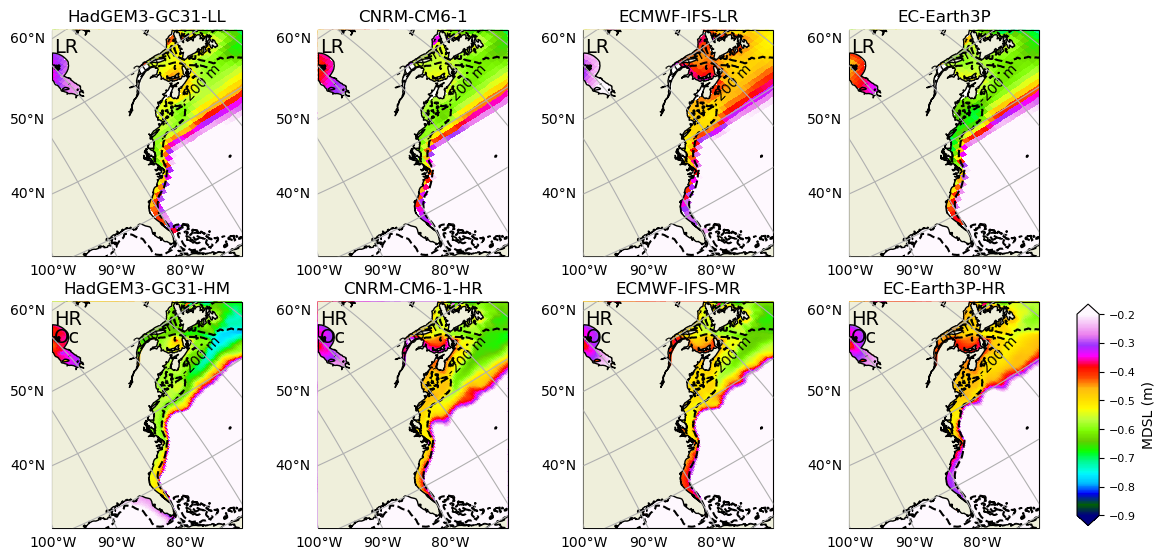

In [17]:
# Modifying the color scale to distiguishe the alongcoast MDSL variability
# %%time
import warnings
warnings.filterwarnings( "ignore")#cell edges

pc = []
axes = []
fig = plt.figure(figsize=(20, 10))
vmin = -0.9
vmax = -0.2
rotated_crs = ccrs.RotatedPole(pole_longitude=30, 
                                       pole_latitude=60)
for i in np.arange(1,len(source_ids),1):
    plotdata = models_mdt[i]

    ax = plt.subplot2grid((3,6), (posmat[0,i],posmat[1,i]), colspan=1, rowspan=1, projection=rotated_crs)#, aspect="auto")
    pos = ax.get_position() # get the original position 
    p=plt.pcolormesh(plotdata.longitude ,plotdata.latitude, plotdata,
                     vmin=vmin, vmax=vmax, 
                     #cmap='RdBu_r',
                     cmap='gist_ncar',
                     # cmap='Spectral_r',
                     zorder=1,
                     # shading='flat',
                     transform=ccrs.PlateCarree())
    # CS2 = ax.contour(plotdata.longitude ,plotdata.latitude, plotdata,
    #                 np.arange(vmin,0,vmax),colors='k',linewidths=2,zorder=2,transform=ccrs.PlateCarree())
    #CS2 = ax.contour(plotdata.longitude ,plotdata.latitude, plotdata,
    #                np.arange(vmin,vmax*2,-vmin),colors='k',linewidths=1,zorder=2,transform=ccrs.PlateCarree())
    #ax.clabel(CS2, CS2.levels, inline=True, colors='k',fontsize=10,fmt='%1.2f')

    ax.set_extent([-71,-75,20,60], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND.with_scale('110m'),zorder=4)
    ax.add_feature(cfeature.COASTLINE, edgecolor="black",zorder=4) 
    #ax.add_feature(cfeature.STATES, edgecolor="black",zorder=4) 
    # ax.scatter(tgs_temp[tgind].real_coords[1], tgs_temp[tgind].real_coords[0], s=200, marker='*', color='k', zorder=7, transform=ccrs.PlateCarree())
    # ax.scatter(tgs_temp[tgind2].real_coords[1], tgs_temp[tgind2].real_coords[0], s=100, marker='*', color='k', zorder=5, transform=ccrs.PlateCarree())
    # ax.scatter(tgs_temp[tgind3].real_coords[1], tgs_temp[tgind3].real_coords[0], s=100, marker='*', color='k', zorder=5, transform=ccrs.PlateCarree())
    # ax.text(.01,.95, source_ids[i], transform=ax.transAxes, fontsize=12,zorder=6)
    ax.set_title(source_ids[i],loc='center')

    if i<1:
        ax.text(.01,.90, 'OBS', transform=ax.transAxes, fontsize=14,zorder=6)
    else:
        if posmat[0,i]<1:
            ax.text(.01,.90, 'LR', transform=ax.transAxes, fontsize=14,zorder=6)
        else:
            if posmat[0,i]<2:
                ax.text(.01,.90, 'HR', transform=ax.transAxes, fontsize=14,zorder=6)
                ax.text(.01,.82, 'Oc', transform=ax.transAxes, fontsize=14,zorder=6)
            else:
                ax.text(.01,.82, 'Oc+Atm', transform=ax.transAxes, fontsize=14,zorder=6)
                ax.text(.01,.90, 'HR', transform=ax.transAxes, fontsize=14,zorder=6)

    # Plot 200m bathymetry contour line
    CS_bathy = ax.contour(ds_bathy.longitude, ds_bathy.latitude, ds_bathy.depth, 
                          levels=[-200],  # Bathymetry depth contour at 200m
                          colors='black',  # Choose contour color
                          linewidths=1.5, 
                          zorder=3, 
                          transform=ccrs.PlateCarree())

# Label the contour line
    ax.clabel(CS_bathy, CS_bathy.levels, inline=True, fontsize=10, fmt='%d m')
        
    # ax.text(.01,.9, bias[i], transform=ax.transAxes, fontsize=10,zorder=6)
    # axes.append(ax)
    # print('Done with ' + source_ids[i])
    gl = ax.gridlines(draw_labels=False, dms=True, x_inline=False, y_inline=False,zorder=6)
    #if nsp<1:
    gl.ylabels_left = True
    #if nreg>(len(reginfo)-2): 
    gl.xlabels_bottom = True
# right_row_pc = [pc[1], pc[3]]
cbar_ax = fig.add_axes(
    [pos.x1+(pos.x1 - pos.x0) / 10, pos.y0, (pos.x1 - pos.x0)/10, (pos.y1 - pos.y0)]
)
cbar = fig.colorbar(p, orientation="vertical", cax=cbar_ax, extend="both",ticklocation='right')
# cbar.ax.set_title("EOF" + str(nsp+1), rotation=0, size=10, weight="bold")
cbar.ax.tick_params(labelsize=8)
# cbar = fig.colorbar(pc[0], ax=axes, orientation='vertical', fraction=0.03, pad=0.1)
cbar.set_label('MDSL (m)')  # Example label, adjust as needed

# #plt.tight_layout()
# plt.show()
plt.savefig('p1_f1.png',
)

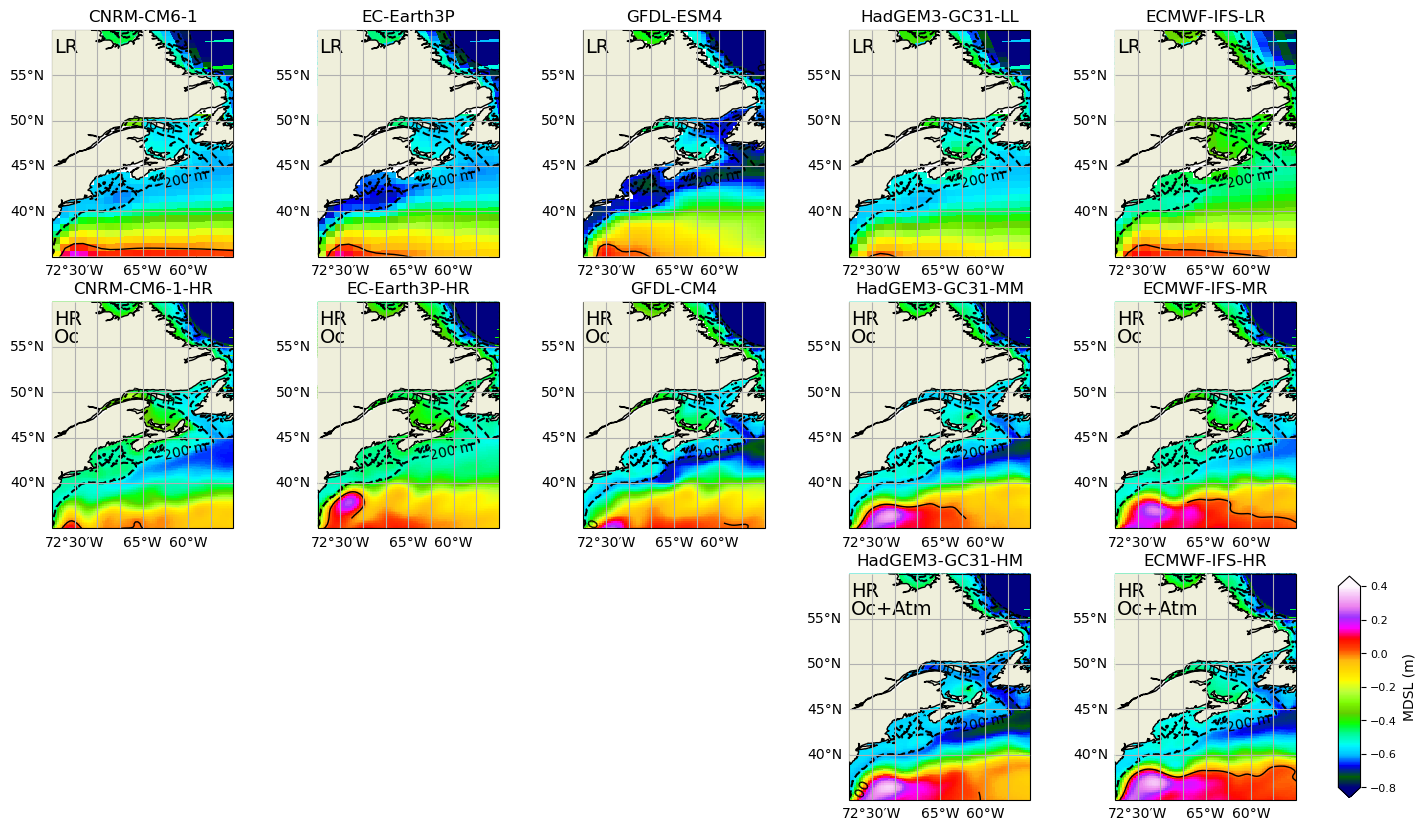

In [16]:
# %%time
import warnings
warnings.filterwarnings( "ignore")#cell edges

pc = []
axes = []
fig = plt.figure(figsize=(20, 10))
vmin = -0.8
vmax = .4
rotated_crs = ccrs.RotatedPole(pole_longitude=30, 
                                       pole_latitude=60)
for i in np.arange(1,len(source_ids),1):
    plotdata = models_mdt[i]

    ax = plt.subplot2grid((3,6), (posmat[0,i],posmat[1,i]), colspan=1, rowspan=1, projection=ccrs.PlateCarree())#, aspect="auto")
    pos = ax.get_position() # get the original position 
    p=plt.pcolormesh(plotdata.longitude ,plotdata.latitude, plotdata,
                     vmin=vmin, vmax=vmax, 
                      #cmap='RdBu_r',
                     cmap='gist_ncar',
                     # cmap='Spectral_r',
                     zorder=1,
                     # shading='flat',
                     transform=ccrs.PlateCarree())
    # CS2 = ax.contour(plotdata.longitude ,plotdata.latitude, plotdata,
    #                 np.arange(vmin,0,vmax),colors='k',linewidths=2,zorder=2,transform=ccrs.PlateCarree())
    CS2 = ax.contour(plotdata.longitude ,plotdata.latitude, plotdata,
                    np.arange(vmin,vmax*2,-vmin),colors='k',linewidths=1,zorder=2,transform=ccrs.PlateCarree())
    ax.clabel(CS2, CS2.levels, inline=True, colors='k',fontsize=10,fmt='%1.2f')

    ax.set_extent([-55,-75,35,60], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND.with_scale('110m'),zorder=4)
    ax.add_feature(cfeature.COASTLINE, edgecolor="black",zorder=4) 
    #ax.add_feature(cfeature.STATES, edgecolor="black",zorder=4) 
    # ax.scatter(tgs_temp[tgind].real_coords[1], tgs_temp[tgind].real_coords[0], s=200, marker='*', color='k', zorder=7, transform=ccrs.PlateCarree())
    # ax.scatter(tgs_temp[tgind2].real_coords[1], tgs_temp[tgind2].real_coords[0], s=100, marker='*', color='k', zorder=5, transform=ccrs.PlateCarree())
    # ax.scatter(tgs_temp[tgind3].real_coords[1], tgs_temp[tgind3].real_coords[0], s=100, marker='*', color='k', zorder=5, transform=ccrs.PlateCarree())
    # ax.text(.01,.95, source_ids[i], transform=ax.transAxes, fontsize=12,zorder=6)
    ax.set_title(source_ids[i],loc='center')

    if i<1:
        ax.text(.01,.90, 'OBS', transform=ax.transAxes, fontsize=14,zorder=6)
    else:
        if posmat[0,i]<1:
            ax.text(.01,.90, 'LR', transform=ax.transAxes, fontsize=14,zorder=6)
        else:
            if posmat[0,i]<2:
                ax.text(.01,.90, 'HR', transform=ax.transAxes, fontsize=14,zorder=6)
                ax.text(.01,.82, 'Oc', transform=ax.transAxes, fontsize=14,zorder=6)
            else:
                ax.text(.01,.82, 'Oc+Atm', transform=ax.transAxes, fontsize=14,zorder=6)
                ax.text(.01,.90, 'HR', transform=ax.transAxes, fontsize=14,zorder=6)

    # Plot 200m bathymetry contour line
    CS_bathy = ax.contour(ds_bathy.longitude, ds_bathy.latitude, ds_bathy.depth, 
                          levels=[-200],  # Bathymetry depth contour at 200m
                          colors='black',  # Choose contour color
                          linewidths=1.5, 
                          zorder=3, 
                          transform=ccrs.PlateCarree())

# Label the contour line
    ax.clabel(CS_bathy, CS_bathy.levels, inline=True, fontsize=10, fmt='%d m')
        
    # ax.text(.01,.9, bias[i], transform=ax.transAxes, fontsize=10,zorder=6)
    # axes.append(ax)
    # print('Done with ' + source_ids[i])
    gl = ax.gridlines(draw_labels=False, dms=True, x_inline=False, y_inline=False,zorder=6)
    #if nsp<1:
    gl.ylabels_left = True
    ##if nreg>(len(reginfo)-2): 
    gl.xlabels_bottom = True
# right_row_pc = [pc[1], pc[3]]
cbar_ax = fig.add_axes(
    [pos.x1+(pos.x1 - pos.x0) / 10, pos.y0, (pos.x1 - pos.x0)/10, (pos.y1 - pos.y0)]
)
cbar = fig.colorbar(p, orientation="vertical", cax=cbar_ax, extend="both",ticklocation='right')
# cbar.ax.set_title("EOF" + str(nsp+1), rotation=0, size=10, weight="bold")
cbar.ax.tick_params(labelsize=8)
# cbar = fig.colorbar(pc[0], ax=axes, orientation='vertical', fraction=0.03, pad=0.1)
cbar.set_label('MDSL (m)')  # Example label, adjust as needed

# #plt.tight_layout()
# plt.show()
plt.savefig('p1_f1.png',
)

### Relative to tide gauge

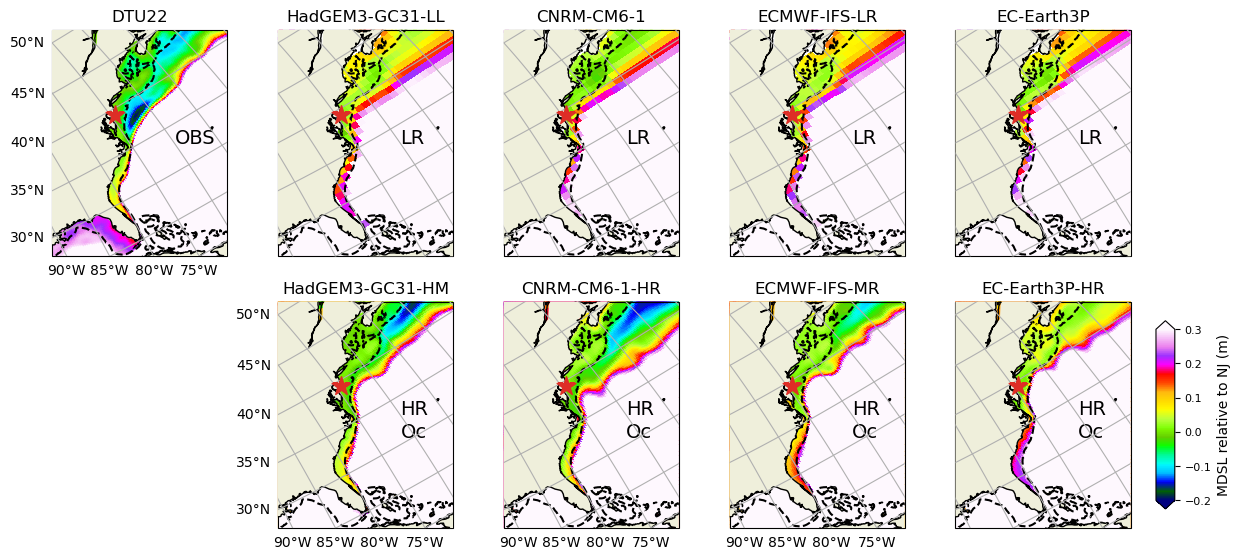

In [18]:
# %%time
import warnings
warnings.filterwarnings( "ignore")#cell edges

pc = []
axes = []
fig = plt.figure(figsize=(17, 10))
vmin = -0.2
vmax = .3
rotated_crs = ccrs.RotatedPole(pole_longitude=30, 
                                       pole_latitude=60)
for i in np.arange(len(source_ids)):

    plotdata = models_mdt_rel_tgs[i]
    ax = plt.subplot2grid((3,6), (posmat[0,i],posmat[1,i]), colspan=1, rowspan=1, projection=rotated_crs)#, aspect="auto")
    pos = ax.get_position() # get the original position 
    p=plt.pcolormesh(plotdata.longitude ,plotdata.latitude, plotdata,
                     vmin=vmin, vmax=vmax, 
                     # cmap='RdBu_r',
                     cmap='gist_ncar',
                     # cmap='Spectral_r',
                     zorder=1,
                     # shading='flat',
                     transform=ccrs.PlateCarree())
    # CS2 = ax.contour(plotdata.longitude ,plotdata.latitude, plotdata,
    #                 np.arange(vmin,0,vmax),colors='k',linewidths=2,zorder=2,transform=ccrs.PlateCarree())
    #CS2 = ax.contour(plotdata.longitude ,plotdata.latitude, plotdata,
    #                np.arange(vmin,vmax*2,-vmin),colors='k',linewidths=1,zorder=2,transform=ccrs.PlateCarree())
    #ax.clabel(CS2, CS2.levels, inline=True, colors='k',fontsize=10,fmt='%1.2f')

    # Plot 200m bathymetry contour line
    CS_bathy = ax.contour(ds_bathy.longitude, ds_bathy.latitude, ds_bathy.depth, 
                          levels=[-200],  # Bathymetry depth contour at 200m
                          colors='black',  # Choose contour color
                          linewidths=1.5, 
                          zorder=3, 
                          transform=ccrs.PlateCarree())
    
    ax.set_extent([-71,-75,20,50], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND.with_scale('110m'),zorder=4)
    ax.add_feature(cfeature.COASTLINE, edgecolor="black",zorder=4) 
    #ax.add_feature(cfeature.STATES, edgecolor="black",zorder=4) 
    ax.scatter(tgs_temp[tgind].real_coords[1], tgs_temp[tgind].real_coords[0], s=200, marker='*', color='#de2d26', zorder=7, transform=ccrs.PlateCarree())
    # ax.scatter(tgs_temp[tgind2].real_coords[1], tgs_temp[tgind2].real_coords[0], s=100, marker='*', color='k', zorder=5, transform=ccrs.PlateCarree())
    # ax.scatter(tgs_temp[tgind3].real_coords[1], tgs_temp[tgind3].real_coords[0], s=100, marker='*', color='k', zorder=5, transform=ccrs.PlateCarree())
    # ax.text(.01,.95, source_ids[i], transform=ax.transAxes, fontsize=12,zorder=6)
    ax.set_title(source_ids[i],loc='center')

    if i<1:
        ax.text(.7,.5, 'OBS', transform=ax.transAxes, fontsize=14,zorder=6)
    else:
        if posmat[0,i]<1:
            ax.text(.7,.5, 'LR', transform=ax.transAxes, fontsize=14,zorder=6)
        else:
            if posmat[0,i]<2:
                ax.text(.7,.5, 'HR', transform=ax.transAxes, fontsize=14,zorder=6)
                ax.text(.7,.4, 'Oc', transform=ax.transAxes, fontsize=14,zorder=6)
            else:
                ax.text(.5,.4, 'Oc+Atm', transform=ax.transAxes, fontsize=14,zorder=6)
                ax.text(.5,.5, 'HR', transform=ax.transAxes, fontsize=14,zorder=6)
        
    # ax.text(.01,.9, bias[i], transform=ax.transAxes, fontsize=10,zorder=6)
    # axes.append(ax)
    # print('Done with ' + source_ids[i])
    gl = ax.gridlines(draw_labels=False, dms=True, x_inline=False, y_inline=False,zorder=6)
    # if nsp<1:
    if i in [0, 2, 9]:
        gl.ylabels_left = True

    if i in [0, 2, 4, 6, 9, 12]:
        gl.xlabels_bottom = True
# right_row_pc = [pc[1], pc[3]]
cbar_ax = fig.add_axes(
    [pos.x1+(pos.x1 - pos.x0) / 10, pos.y0, (pos.x1 - pos.x0)/10, (pos.y1 - pos.y0)]
)
cbar = fig.colorbar(p, orientation="vertical", cax=cbar_ax, extend="both",ticklocation='right')
# cbar.ax.set_title("EOF" + str(nsp+1), rotation=0, size=10, weight="bold")
cbar.ax.tick_params(labelsize=8)
# cbar = fig.colorbar(pc[0], ax=axes, orientation='vertical', fraction=0.03, pad=0.1)
cbar.set_label('MDSL relative to NJ (m)')  # Example label, adjust as needed

# #plt.tight_layout()
# plt.show()
plt.savefig('p1_f1.png',
)

In [18]:
print(source_ids)

['DTU22', 'CNRM-CM6-1', 'CNRM-CM6-1-HR', 'EC-Earth3P', 'EC-Earth3P-HR', 'GFDL-ESM4', 'GFDL-CM4', 'HadGEM3-GC31-LL', 'HadGEM3-GC31-MM', 'HadGEM3-GC31-HM', 'ECMWF-IFS-LR', 'ECMWF-IFS-MR', 'ECMWF-IFS-HR']


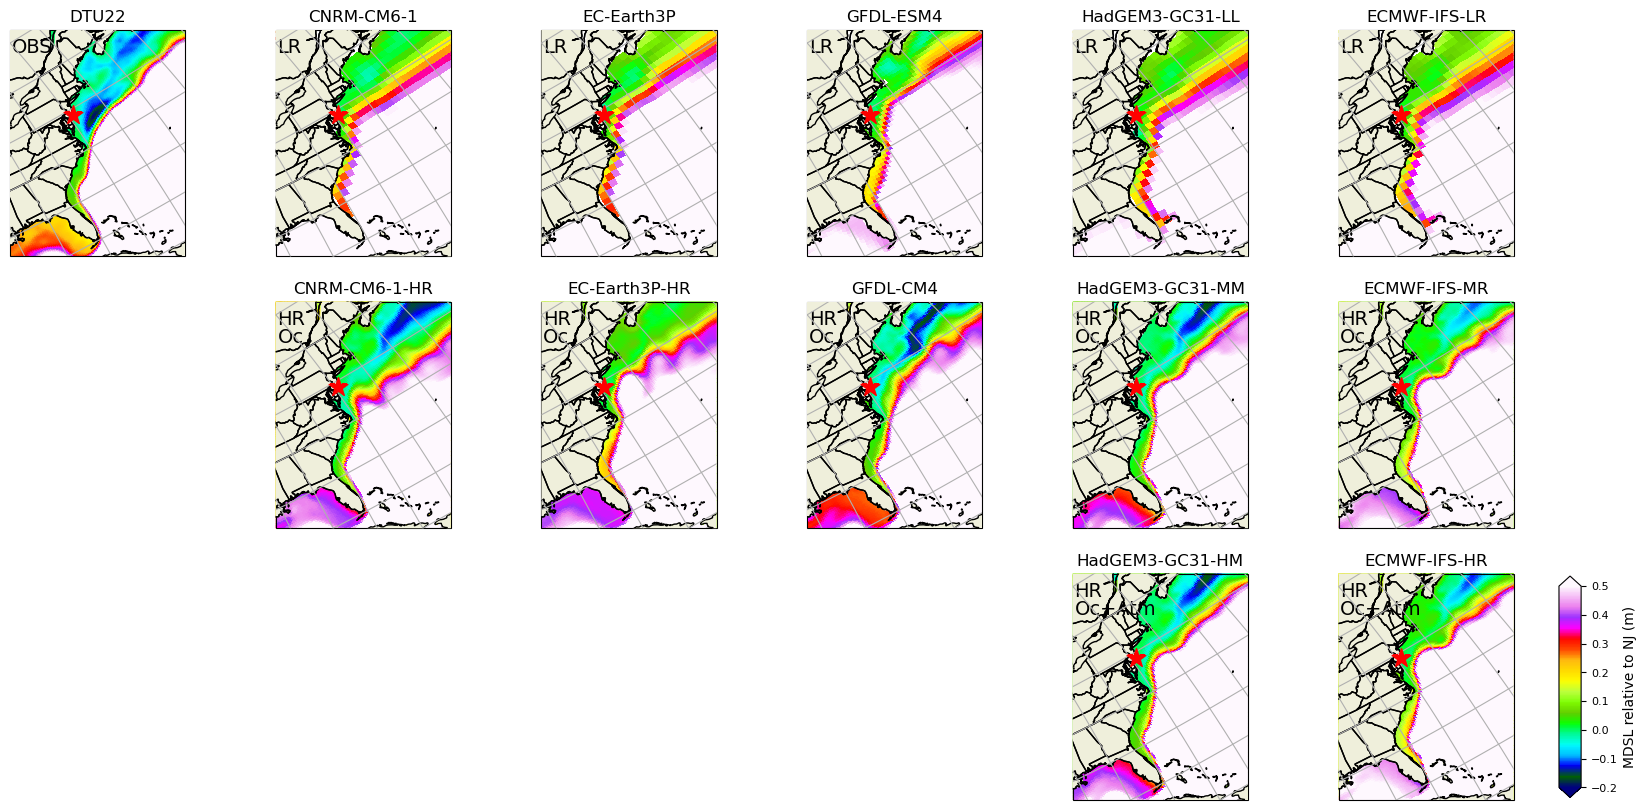

In [19]:
# %%time
import warnings
warnings.filterwarnings( "ignore")#cell edges

pc = []
axes = []
fig = plt.figure(figsize=(20, 10))
vmin = -0.2
vmax = .5
rotated_crs = ccrs.RotatedPole(pole_longitude=30, 
                                       pole_latitude=60)
for i in np.arange(len(source_ids)):

    plotdata = models_mdt_rel_tgs[i]
    ax = plt.subplot2grid((3,6), (posmat[0,i],posmat[1,i]), colspan=1, rowspan=1, projection=rotated_crs)#, aspect="auto")
    pos = ax.get_position() # get the original position 
    p=plt.pcolormesh(plotdata.longitude ,plotdata.latitude, plotdata,
                     vmin=vmin, vmax=vmax, 
                     # cmap='RdBu_r',
                     cmap='gist_ncar',
                     # cmap='Spectral_r',
                     zorder=1,
                     # shading='flat',
                     transform=ccrs.PlateCarree())
    # CS2 = ax.contour(plotdata.longitude ,plotdata.latitude, plotdata,
    #                 np.arange(vmin,0,vmax),colors='k',linewidths=2,zorder=2,transform=ccrs.PlateCarree())
    #CS2 = ax.contour(plotdata.longitude ,plotdata.latitude, plotdata,
    #                np.arange(vmin,vmax*2,-vmin),colors='k',linewidths=1,zorder=2,transform=ccrs.PlateCarree())
    #ax.clabel(CS2, CS2.levels, inline=True, colors='k',fontsize=10,fmt='%1.2f')

    ax.set_extent([-71,-75,20,50], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND.with_scale('110m'),zorder=4)
    ax.add_feature(cfeature.COASTLINE, edgecolor="black",zorder=4) 
    ax.add_feature(cfeature.STATES, edgecolor="black",zorder=4) 
    ax.scatter(tgs_temp[tgind].real_coords[1], tgs_temp[tgind].real_coords[0], s=200, marker='*', color='r', zorder=7, transform=ccrs.PlateCarree())
    # ax.scatter(tgs_temp[tgind2].real_coords[1], tgs_temp[tgind2].real_coords[0], s=100, marker='*', color='k', zorder=5, transform=ccrs.PlateCarree())
    # ax.scatter(tgs_temp[tgind3].real_coords[1], tgs_temp[tgind3].real_coords[0], s=100, marker='*', color='k', zorder=5, transform=ccrs.PlateCarree())
    # ax.text(.01,.95, source_ids[i], transform=ax.transAxes, fontsize=12,zorder=6)
    ax.set_title(source_ids[i],loc='center')

    if i<1:
        ax.text(.01,.90, 'OBS', transform=ax.transAxes, fontsize=14,zorder=6)
    else:
        if posmat[0,i]<1:
            ax.text(.01,.90, 'LR', transform=ax.transAxes, fontsize=14,zorder=6)
        else:
            if posmat[0,i]<2:
                ax.text(.01,.90, 'HR', transform=ax.transAxes, fontsize=14,zorder=6)
                ax.text(.01,.82, 'Oc', transform=ax.transAxes, fontsize=14,zorder=6)
            else:
                ax.text(.01,.82, 'Oc+Atm', transform=ax.transAxes, fontsize=14,zorder=6)
                ax.text(.01,.90, 'HR', transform=ax.transAxes, fontsize=14,zorder=6)
        
    # ax.text(.01,.9, bias[i], transform=ax.transAxes, fontsize=10,zorder=6)
    # axes.append(ax)
    # print('Done with ' + source_ids[i])
    gl = ax.gridlines(draw_labels=False, dms=True, x_inline=False, y_inline=False,zorder=6)
    # if nsp<1:
    #     gl.ylabels_left = True
    # if nreg>(len(reginfo)-2): 
    #     gl.xlabels_bottom = True
# right_row_pc = [pc[1], pc[3]]
cbar_ax = fig.add_axes(
    [pos.x1+(pos.x1 - pos.x0) / 10, pos.y0, (pos.x1 - pos.x0)/10, (pos.y1 - pos.y0)]
)
cbar = fig.colorbar(p, orientation="vertical", cax=cbar_ax, extend="both",ticklocation='right')
# cbar.ax.set_title("EOF" + str(nsp+1), rotation=0, size=10, weight="bold")
cbar.ax.tick_params(labelsize=8)
# cbar = fig.colorbar(pc[0], ax=axes, orientation='vertical', fraction=0.03, pad=0.1)
cbar.set_label('MDSL relative to NJ (m)')  # Example label, adjust as needed

# #plt.tight_layout()
# plt.show()
plt.savefig('p1_f1.png',
)

* General structure represented in HR, improved slope current SSH depression, lower N/S alongcoast tilt
* MDSL/slope current biases are dramatically improved when ocean model resolution is increased to ¼ degree
* But, ¼ degree resolution is not a guarantee of an adequate slope current representation.
* Gulf coast improved, but also uniformly too high.

* All have displaced GS, but some do pretty well with coastal tilt: why is there a disconnect here
  * Either very small scale bias reduction in detachment region, or GS bias isn’t relevant to coastal sea level?

In [20]:
RMSE=((tgs_coast[:,0:-1]-tgs_coast[0,0:-1])**2)/len(tgs_coast[0,0:-1].T)
RMSE=RMSE.sum(axis=1)**0.5
inds=np.argsort((RMSE))
# inds
# posmat

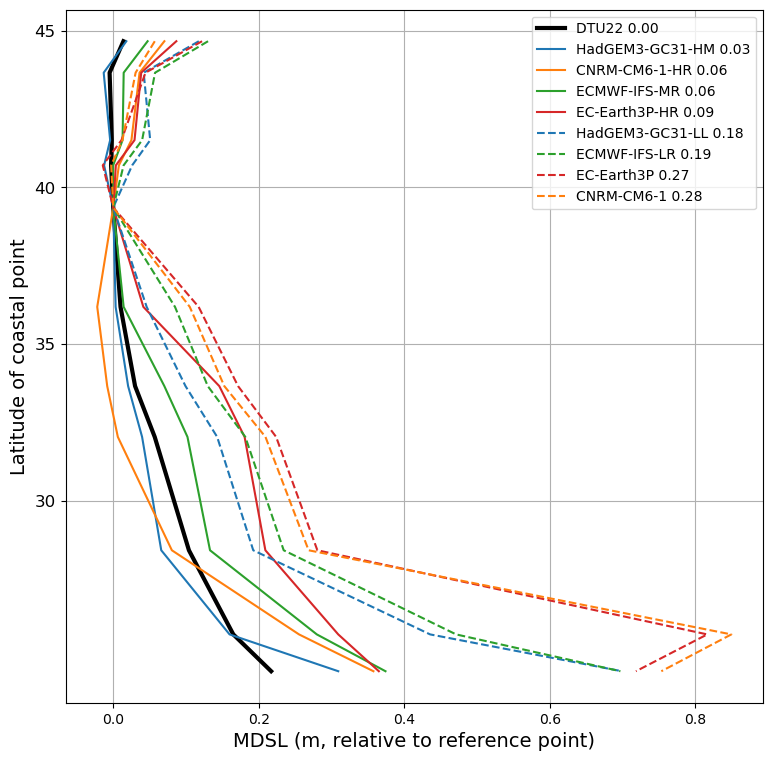

In [21]:
#merge with MDTF diagnostics
fig = plt.figure(figsize=(9, 9))
tglat=pd.read_csv(tgcsvin)
tglat=tglat['lat'].values
cols=['k','C0','C1','C2','C3','C4','C5','C6']

for nmod in inds:
    if nmod<1:
        plt.plot(tgs_coast[nmod,0:-1].T,tglat[0:-1],'k',lw=3,color=cols[posmat[1,nmod]])
    else:
        if posmat[0,nmod]<1:
            plt.plot(tgs_coast[nmod,0:-1].T,tglat[0:-1],ls='--',color=cols[posmat[1,nmod]])
        else:
            if posmat[0,nmod]<2:
                plt.plot(tgs_coast[nmod,0:-1].T,tglat[0:-1],ls='-',color=cols[posmat[1,nmod]])
            else:
                plt.plot(tgs_coast[nmod,0:-1].T,tglat[0:-1],ls=':',color=cols[posmat[1,nmod]])

plt.legend([source_ids[nmod] + ' ' + "{:.2f}".format(RMSE[nmod]) for nmod in inds])
plt.ylabel('Latitude of coastal point', fontsize=14)
plt.xlabel('MDSL (m, relative to reference point)', fontsize=14)
plt.yticks([30,35,40,45], fontsize=12)
plt.grid()
    # plt.legend([source_ids[i] for i in lrlist+hrlist+obslist])
plt.savefig('p1_f2.png',
)

* Zoom in on alongcoast tilt on native grid (update this plot to include observational uncertainty on TG-based estimate, from MDTF PODs)
* Ranked by RMSE across 8 locations
* LR (dashed lines) steeper to the North and south of Mid-Atlantic

In [17]:
%%time

models_mdt_cons=[]
models_shelf_mdt_cons=[]
regrid_size = 1.0
destgrid = generate_global_grid(regrid_size)

ds_bathy = xr.open_dataset(inputdir+"/obs/GEBCO.nc")
ds_bathy= cutdomain(ds_bathy, margin)
regrddr = xe.Regridder(ds_bathy, destgrid, "conservative",ignore_degenerate=True)
depth = regrddr(ds_bathy.depth,skipna=True, na_thres=1)

dmask=(depth>-1000)

for i in range(len(source_ids)):
# for i in [4]:
    ds_model= ds_models[i]
    if (source_ids[i]=="DTU22"):
        regrddr = xe.Regridder(ds_model, destgrid, "conservative",ignore_degenerate=True)
        temp = regrddr(models_mdt[i],skipna=True, na_thres=1)
        model_mdt_cons = temp
        dtu_mdt = model_mdt_cons
    else:
        lat_corners = cfxr.bounds_to_vertices(ds_model.vertices_latitude, "vertices", order=None)
        lon_corners = cfxr.bounds_to_vertices(ds_model.vertices_longitude, "vertices", order=None)
        temp = ds_model.assign(lon_b=lon_corners, lat_b=lat_corners)
        regrddr = xe.Regridder(temp, destgrid, "conservative",ignore_degenerate=True)#,parallel=True)
        temp = regrddr(models_mdt[i],skipna=True, na_thres=1)   
        model_mdt_cons = temp#-dtu_mdt
        
    models_shelf_mdt_cons.append(dmask*model_mdt_cons)        
    models_mdt_cons.append(model_mdt_cons)
    print('Done with ' + source_ids[i])
# models_mdt_cons

Done with DTU22
Done with CNRM-CM6-1
Done with CNRM-CM6-1-HR
Done with EC-Earth3P
Done with EC-Earth3P-HR
Done with GFDL-ESM4
Done with GFDL-CM4
Done with HadGEM3-GC31-LL
Done with HadGEM3-GC31-MM
Done with HadGEM3-GC31-HM
Done with ECMWF-IFS-LR
Done with ECMWF-IFS-MR
Done with ECMWF-IFS-HR
CPU times: user 1min 3s, sys: 880 ms, total: 1min 4s
Wall time: 1min 10s


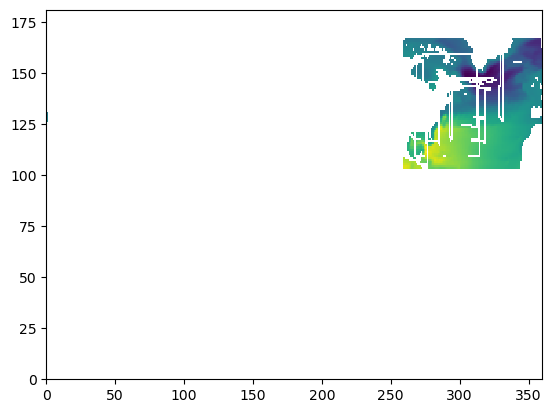

In [16]:
plt.pcolormesh(models_mdt_cons[4]) #fix EC-earth

5
7
10
3
1
CPU times: user 2.61 s, sys: 8.92 ms, total: 2.62 s
Wall time: 2.67 s


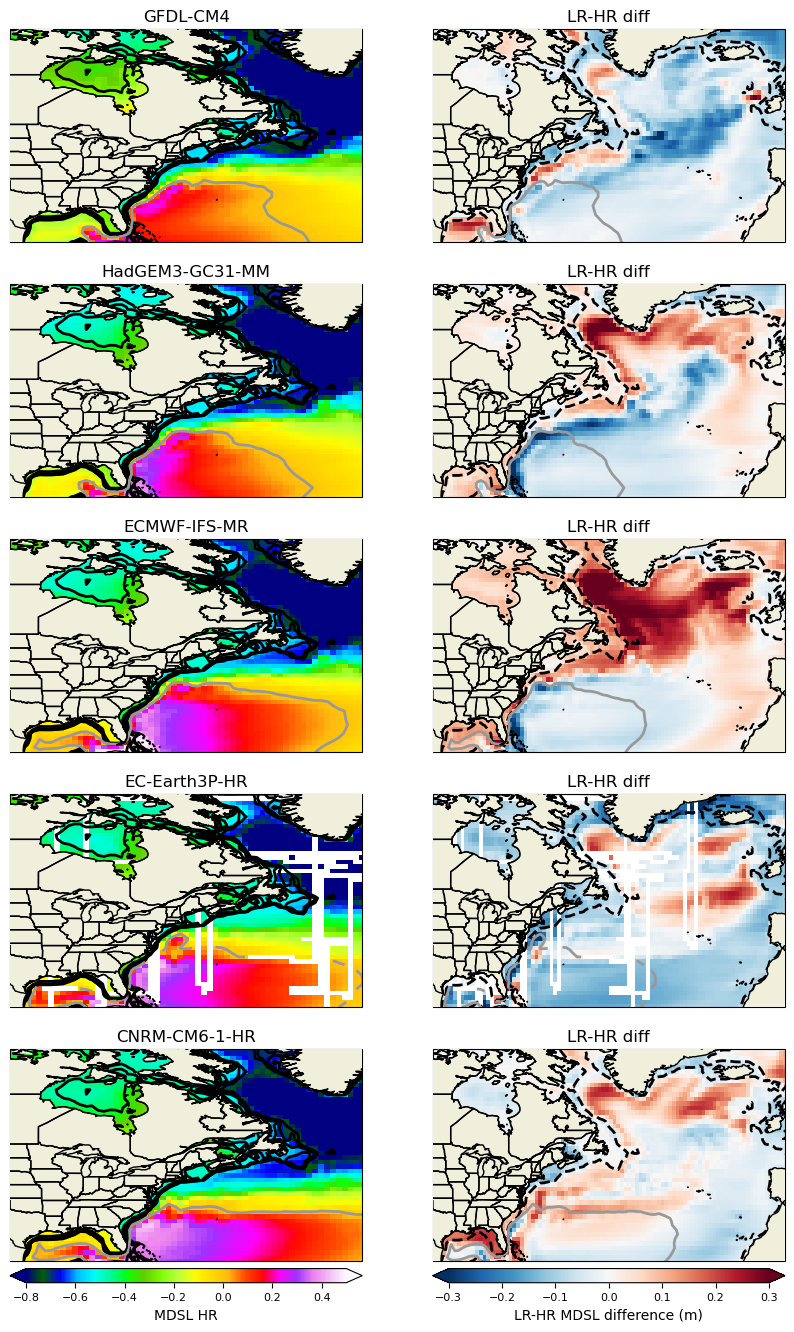

In [18]:
%%time
pc = []
axes = []
fig = plt.figure(figsize=(10, 16))


bias_diff=[]
indic=np.argsort(RMSE[lrlist])
for i in np.arange(len(lrlist)):
    nmod=lrlist[indic[i]]
    print(nmod)
    tt=((models_mdt_cons[nmod])-(models_mdt_cons[nmod+1]))
    bias_diff.append(tt)

    ax = plt.subplot2grid((5,2), (i,0), colspan=1, rowspan=1, projection=ccrs.PlateCarree(),aspect="auto")
    vmin = -0.8
    vmax = .5
    pos = ax.get_position() # get the original position 
    plotdata = models_mdt_cons[nmod+1]
    p=plt.pcolormesh(plotdata.lon ,plotdata.lat, plotdata,
                     vmin=vmin, vmax=vmax, 
                     cmap='gist_ncar',
                     zorder=1,
                     transform=ccrs.PlateCarree())
    CS2 = ax.contour(plotdata.lon ,plotdata.lat, -depth,
                    np.arange(0,500,100),colors='k',linewidths=2,zorder=2,transform=ccrs.PlateCarree())
    CS2 = ax.contour(plotdata.lon ,plotdata.lat, plotdata,
                    np.arange(0,1,1),colors='.6',linewidths=2,zorder=2,transform=ccrs.PlateCarree())
    ax.set_extent([-100,-40,23,70], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND.with_scale('110m'),zorder=4)
    ax.add_feature(cfeature.COASTLINE, edgecolor="black",zorder=4) 
    ax.add_feature(cfeature.STATES, edgecolor="black",zorder=4) 
    ax.set_title(source_ids[nmod+1],loc='center')

    if i==4:
        cbar_ax = fig.add_axes(
            [pos.x0, pos.y0-(pos.y1 - pos.y0) / 10, (pos.x1 - pos.x0), (pos.y1 - pos.y0)/15]
        )
        cbar = fig.colorbar(p, orientation="horizontal", cax=cbar_ax, extend="both")
        cbar.ax.tick_params(labelsize=8)
        cbar.set_label('MDSL HR')  # Example label, adjust as needed

    # ax = plt.subplot2grid((5,3), (i,1), colspan=1, rowspan=1, projection=ccrs.PlateCarree())
    # pos = ax.get_position() # get the original position 
    # plotdata = models_mdt_cons[nmod]
    # p=plt.pcolormesh(plotdata.lon ,plotdata.lat, plotdata,
    #                  vmin=vmin, vmax=vmax, 
    #                  cmap='RdBu_r',
    #                  zorder=1,
    #                  transform=ccrs.PlateCarree())
    # CS2 = ax.contour(plotdata.lon ,plotdata.lat, -depth,
    #                 np.arange(0,500,100),colors='k',linewidths=2,zorder=2,transform=ccrs.PlateCarree())
    # CS2 = ax.contour(plotdata.lon ,plotdata.lat, plotdata,
    #                 np.arange(0,1,1),colors='.6',linewidths=2,zorder=2,transform=ccrs.PlateCarree())
    # ax.set_extent([-100,-40,23,70], crs=ccrs.PlateCarree())
    # ax.add_feature(cfeature.LAND.with_scale('110m'),zorder=4)
    # ax.add_feature(cfeature.COASTLINE, edgecolor="black",zorder=4) 
    # ax.add_feature(cfeature.STATES, edgecolor="black",zorder=4) 
    # ax.set_title(source_ids[nmod],loc='center')

    # if i==4:
    #     cbar_ax = fig.add_axes(
    #         [pos.x0, pos.y0-(pos.y1 - pos.y0) / 10, (pos.x1 - pos.x0), (pos.y1 - pos.y0)/15]
    #     )
    #     cbar = fig.colorbar(p, orientation="horizontal", cax=cbar_ax, extend="both")
    #     cbar.ax.tick_params(labelsize=8)
    #     cbar.set_label('MDSL bias in LR (relative to NJ, m)')  # Example label, adjust as needed

    ax = plt.subplot2grid((5,2), (i,1), colspan=1, rowspan=1, projection=ccrs.PlateCarree(),aspect="auto")
    vmin = -0.3
    vmax = -vmin
    pos = ax.get_position() # get the original position 
    plotdata1=plotdata
    plotdata = bias_diff[i]
    p=plt.pcolormesh(plotdata.lon ,plotdata.lat, plotdata,
                     vmin=vmin, vmax=vmax, 
                     cmap='RdBu_r',
                     zorder=1,
                     transform=ccrs.PlateCarree())
    CS2 = ax.contour(plotdata.lon ,plotdata.lat, depth,
                    np.arange(-500,-400,100),colors='k',linewidths=2,zorder=2,transform=ccrs.PlateCarree())
    CS2 = ax.contour(plotdata.lon ,plotdata.lat, plotdata1,
                    np.arange(0,1,1),colors='.6',linewidths=2,zorder=2,transform=ccrs.PlateCarree())
    
    ax.set_extent([-100,-5,23,70], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND.with_scale('110m'),zorder=4)
    ax.add_feature(cfeature.COASTLINE, edgecolor="black",zorder=4) 
    ax.add_feature(cfeature.STATES, edgecolor="black",zorder=4) 
    ax.set_title('LR-HR diff',loc='center')

    if i==4:
        cbar_ax = fig.add_axes(
            [pos.x0, pos.y0-(pos.y1 - pos.y0) / 10, (pos.x1 - pos.x0), (pos.y1 - pos.y0)/15]
        )
        cbar = fig.colorbar(p, orientation="horizontal", cax=cbar_ax, extend="both")
        cbar.ax.tick_params(labelsize=8)
        cbar.set_label('LR-HR MDSL difference (m)')  # Example label, adjust as needed

plt.savefig('p1_f3.png',
)

* HR models on left, ranked by coastal RMSE
* Lab sea bias related to the downstream NRG and SH coastal bias?
* Suggests that it is the drivers of the SSH in the slope current region, rather than the STG interior, or communication to the SEUS coast, that is the underlying change with resolution
* Across 5 different paired simulations, improvements in shelf MDSL are more consistently related to slope current/NRG/subpolar gyre biases than gulf stream and/or subtropical gyre biases (F3)

CPU times: user 965 ms, sys: 3.7 ms, total: 968 ms
Wall time: 998 ms


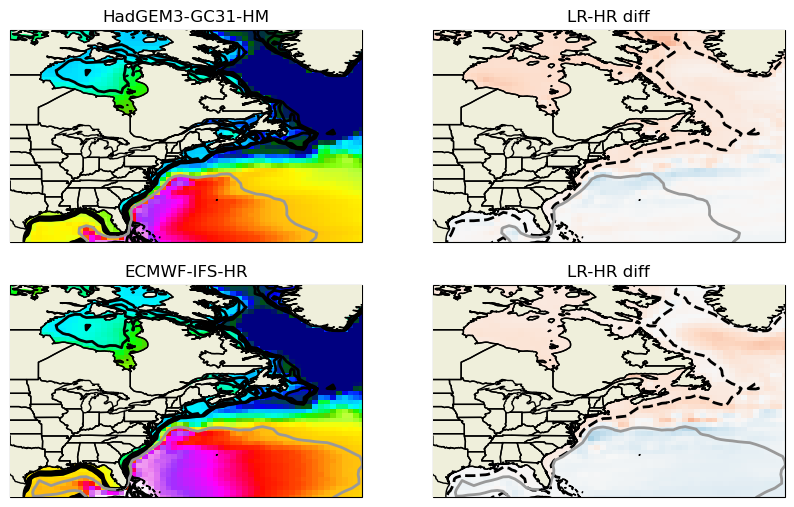

In [18]:
%%time
pc = []
axes = []
fig = plt.figure(figsize=(10, 16))


bias_diff=[]
indic=np.argsort(RMSE[lrlist])
for i in np.arange(2):
    nmod=lrlist[3+i]+1
    # print(nmod)
    tt=((models_mdt_cons[nmod])-(models_mdt_cons[nmod+1]))
    bias_diff.append(tt)

    ax = plt.subplot2grid((5,2), (i,0), colspan=1, rowspan=1, projection=ccrs.PlateCarree(),aspect="auto")
    vmin = -0.8
    vmax = .5
    pos = ax.get_position() # get the original position 
    plotdata = models_mdt_cons[nmod+1]
    p=plt.pcolormesh(plotdata.lon ,plotdata.lat, plotdata,
                     vmin=vmin, vmax=vmax, 
                     cmap='gist_ncar',
                     zorder=1,
                     transform=ccrs.PlateCarree())
    CS2 = ax.contour(plotdata.lon ,plotdata.lat, -depth,
                    np.arange(0,500,100),colors='k',linewidths=2,zorder=2,transform=ccrs.PlateCarree())
    CS2 = ax.contour(plotdata.lon ,plotdata.lat, plotdata,
                    np.arange(0,1,1),colors='.6',linewidths=2,zorder=2,transform=ccrs.PlateCarree())
    ax.set_extent([-100,-40,23,70], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND.with_scale('110m'),zorder=4)
    ax.add_feature(cfeature.COASTLINE, edgecolor="black",zorder=4) 
    ax.add_feature(cfeature.STATES, edgecolor="black",zorder=4) 
    ax.set_title(source_ids[nmod+1],loc='center')

    if i==4:
        cbar_ax = fig.add_axes(
            [pos.x0, pos.y0-(pos.y1 - pos.y0) / 10, (pos.x1 - pos.x0), (pos.y1 - pos.y0)/15]
        )
        cbar = fig.colorbar(p, orientation="horizontal", cax=cbar_ax, extend="both")
        cbar.ax.tick_params(labelsize=8)
        cbar.set_label('MDSL HR')  # Example label, adjust as needed

    # ax = plt.subplot2grid((5,3), (i,1), colspan=1, rowspan=1, projection=ccrs.PlateCarree())
    # pos = ax.get_position() # get the original position 
    # plotdata = models_mdt_cons[nmod]
    # p=plt.pcolormesh(plotdata.lon ,plotdata.lat, plotdata,
    #                  vmin=vmin, vmax=vmax, 
    #                  cmap='RdBu_r',
    #                  zorder=1,
    #                  transform=ccrs.PlateCarree())
    # CS2 = ax.contour(plotdata.lon ,plotdata.lat, -depth,
    #                 np.arange(0,500,100),colors='k',linewidths=2,zorder=2,transform=ccrs.PlateCarree())
    # CS2 = ax.contour(plotdata.lon ,plotdata.lat, plotdata,
    #                 np.arange(0,1,1),colors='.6',linewidths=2,zorder=2,transform=ccrs.PlateCarree())
    # ax.set_extent([-100,-40,23,70], crs=ccrs.PlateCarree())
    # ax.add_feature(cfeature.LAND.with_scale('110m'),zorder=4)
    # ax.add_feature(cfeature.COASTLINE, edgecolor="black",zorder=4) 
    # ax.add_feature(cfeature.STATES, edgecolor="black",zorder=4) 
    # ax.set_title(source_ids[nmod],loc='center')

    # if i==4:
    #     cbar_ax = fig.add_axes(
    #         [pos.x0, pos.y0-(pos.y1 - pos.y0) / 10, (pos.x1 - pos.x0), (pos.y1 - pos.y0)/15]
    #     )
    #     cbar = fig.colorbar(p, orientation="horizontal", cax=cbar_ax, extend="both")
    #     cbar.ax.tick_params(labelsize=8)
    #     cbar.set_label('MDSL bias in LR (relative to NJ, m)')  # Example label, adjust as needed

    ax = plt.subplot2grid((5,2), (i,1), colspan=1, rowspan=1, projection=ccrs.PlateCarree(),aspect="auto")
    vmin = -0.3
    vmax = -vmin
    pos = ax.get_position() # get the original position 
    plotdata1=plotdata
    plotdata = bias_diff[i]
    p=plt.pcolormesh(plotdata.lon ,plotdata.lat, plotdata,
                     vmin=vmin, vmax=vmax, 
                     cmap='RdBu_r',
                     zorder=1,
                     transform=ccrs.PlateCarree())
    CS2 = ax.contour(plotdata.lon ,plotdata.lat, depth,
                    np.arange(-500,-400,100),colors='k',linewidths=2,zorder=2,transform=ccrs.PlateCarree())
    CS2 = ax.contour(plotdata.lon ,plotdata.lat, plotdata1,
                    np.arange(0,1,1),colors='.6',linewidths=2,zorder=2,transform=ccrs.PlateCarree())
    
    ax.set_extent([-100,-40,23,70], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND.with_scale('110m'),zorder=4)
    ax.add_feature(cfeature.COASTLINE, edgecolor="black",zorder=4) 
    ax.add_feature(cfeature.STATES, edgecolor="black",zorder=4) 
    ax.set_title('LR-HR diff',loc='center')

    if i==4:
        cbar_ax = fig.add_axes(
            [pos.x0, pos.y0-(pos.y1 - pos.y0) / 10, (pos.x1 - pos.x0), (pos.y1 - pos.y0)/15]
        )
        cbar = fig.colorbar(p, orientation="horizontal", cax=cbar_ax, extend="both")
        cbar.ax.tick_params(labelsize=8)
        cbar.set_label('LR-HR MDSL difference (m)')  # Example label, adjust as needed

plt.savefig('p1_f3.png',
)

* Additional increases in atmopsheric resolution do not result in large SSH differences

### Potential conclusions/key points
* Coupled models with higher resolution ocean models better represent MDSL gradients along the USEC coast
* These improvements are associated with reduced biases in the slope current and subpolar gyre, despite diverse improvements in STG and GS relative to LR 
* Variability biases...
<!-- # * These findings across a wide range of timescale, and theoretical arguments, suggest that [slope current and representation of extent to is critical] [coastal wave propagation is blocked by overly strong currents in near coastal grid points (is wave speed influenced by resolution as well?)] -->


### Questions
* Is it coastal or remote forcing?
* Role of atmosphere, ocean in model improvements?
* What resolution is required to achieve an accurate representation? 

## Read in windstress data for HadGEM3-GC31

In [7]:
%%time
# Define available models
mods = [
    #"DTU22",
    #"CNRM-CM6-1",
    #"CNRM-CM6-1-HR",
    #"EC-Earth3P",
    #"EC-Earth3P-HR",
    #"GFDL-ESM4",
    #"GFDL-CM4",
    "HadGEM3-GC31-LL",
    #"HadGEM3-GC31-MM",
    #"HadGEM3-GC31-HM",
    #"ECMWF-IFS-LR",
    #"ECMWF-IFS-MR",
    #"ECMWF-IFS-HR",
    # "CMCC-CM2-HR4",
    # "CMCC-CM2-VHR4",
     "HadGEM3-GC31-HM"
]
ds_models_tauv = []
ds_models_tauu = []

source_ids = mods#[4:6]
for i in range(len(source_ids)):
    source_id=source_ids[i]
    #if (source_id=="DTU22"):
    #    ds_zos = xr.open_dataset("/glade/work/clittle/p2521/input/obs/dtuuh22mdt.nc")
    #else:
    #    if (source_id=="GFDL-ESM4") or (source_id=="GFDL-CM4"):
    #        ds_zos = xr.open_mfdataset(inputdir2+'zos_Omon_'+source_id+'*.nc')
    #        ds_zos = ds_zos.rename({'y':'j', 'x':'i','lat':'latitude', 'lon':'longitude'})#.drop(#['lon']#=ds_grid.geolon.values
    #    else:
    filepath_v = f'/glade/work/netige/Data/CMIP6_Downloader/data/s_{source_id}_e_hist-1950_vl_r1i*_f_mon_v_tauvo/'
    ds_tauv_flist1 = sorted(glob.glob(filepath_v+f'/tauvo_Omon_{source_id}_hist-1950_r1i*_gn_199*.nc'))
    ds_tauv_flist2 = sorted(glob.glob(filepath_v+f'/tauvo_Omon_{source_id}_hist-1950_r1i*_gn_200*.nc'))#[0-9].nc'))
    ds_tauv_flist3 = sorted(glob.glob(filepath_v+f'/tauvo_Omon_{source_id}_hist-1950_r1i*_gn_201*.nc'))
    ds_tauv_flist = (ds_tauv_flist1+ds_tauv_flist2+ds_tauv_flist3)
    ds_tauv = xr.open_mfdataset(ds_tauv_flist)        # print(i)
        
    # #Check if model dimensions are compatible to run cutdomain. If not modify model dimensions
    ds_tauv = model_dim_check(ds_tauv)

    filepath_u = f'/glade/work/netige/Data/CMIP6_Downloader/data/s_{source_id}_e_hist-1950_vl_r1i*_f_mon_v_tauuo/'
    ds_tauu_flist1 = sorted(glob.glob(filepath_u+f'/tauuo_Omon_{source_id}_hist-1950_r1i*_gn_199*.nc'))
    ds_tauu_flist2 = sorted(glob.glob(filepath_u+f'/tauuo_Omon_{source_id}_hist-1950_r1i*_gn_200*.nc'))#[0-9].nc'))
    ds_tauu_flist3 = sorted(glob.glob(filepath_u+f'/tauuo_Omon_{source_id}_hist-1950_r1i*_gn_201*.nc'))
    ds_tauu_flist = (ds_tauu_flist1+ds_tauu_flist2+ds_tauu_flist3)
    ds_tauu = xr.open_mfdataset(ds_tauu_flist)        # print(i)
        
    # #Check if model dimensions are compatible to run cutdomain. If not modify model dimensions
    ds_tauu = model_dim_check(ds_tauu)
    
    # #Select region of interest IF regridding
    min_lon = 260
    max_lon = 320
    min_lat = 15
    max_lat = 60
    min_lon = 260
    max_lon = 360
    min_lat = 15
    max_lat = 75
    # max_lat = 20
    ds_tauv= cutdomain(ds_tauv, margin)
    ds_tauu= cutdomain(ds_tauu, margin)

    if (source_id=="DTU22"):
        ds_model = ds_zos.rename({'mdt':'zos'}).drop_vars('err_mdt')
    else:
        ds_model_tauv = ds_tauv.groupby("time.year").mean().sel(year=slice('1993','2012'))
        ds_model_tauu = ds_tauu.groupby("time.year").mean().sel(year=slice('1993','2012'))
        
        ds_model_tauv=ds_model_tauv.mean(dim='year')
        ds_model_tauu=ds_model_tauu.mean(dim='year')
    
    ds_models_tauv.append(ds_model_tauv)
    ds_models_tauu.append(ds_model_tauu)
    print('Done with ' + source_ids[i])
# ds_models

i dimension is larger than j dimension. Therefore, dimension names need to be swapped
dimension names swapped
longitude ranges from -180 to 180. This needs to be changed as 0 to 360
longitude values changed
i dimension is larger than j dimension. Therefore, dimension names need to be swapped
dimension names swapped
longitude ranges from -180 to 180. This needs to be changed as 0 to 360
longitude values changed
Done with HadGEM3-GC31-LL
i dimension is larger than j dimension. Therefore, dimension names need to be swapped
dimension names swapped
longitude ranges from -180 to 180. This needs to be changed as 0 to 360
longitude values changed
i dimension is larger than j dimension. Therefore, dimension names need to be swapped
dimension names swapped
longitude ranges from -180 to 180. This needs to be changed as 0 to 360
longitude values changed
Done with HadGEM3-GC31-HM
CPU times: user 8.13 s, sys: 1.24 s, total: 9.38 s
Wall time: 19.7 s


## Compute windstress magnitude

In [8]:
ds_models_tauv[0].tauvo

<xarray.DataArray 'tauvo' (i: 116, j: 102)>
dask.array<mean_agg-aggregate, shape=(116, 102), dtype=float32, chunksize=(93, 102), chunktype=numpy.ndarray>
Coordinates:
  * i          (i) int32 213 214 215 216 217 218 219 ... 323 324 325 326 327 328
  * j          (j) int32 185 186 187 188 189 190 191 ... 281 282 283 284 285 286
    latitude   (i, j) float32 13.52 13.52 13.52 13.52 ... 81.7 81.25 80.8 80.34
    longitude  (i, j) float32 258.5 259.5 260.5 261.5 ... 70.1 70.25 70.38 70.51

In [9]:
magnitudes = []

for i in range(len(source_ids)):
    tauu = ds_models_tauu[i].tauuo
    tauv = ds_models_tauv[i].tauvo

    # Compute derived variables
    magnitude = np.sqrt(tauu**2 + tauv**2)

    magnitudes.append(magnitude)
    
    print('Done with ' + source_ids[i])

Done with HadGEM3-GC31-LL
Done with HadGEM3-GC31-HM


In [10]:
magnitudes


[<xarray.DataArray (i: 116, j: 101)>
 dask.array<sqrt, shape=(116, 101), dtype=float32, chunksize=(93, 101), chunktype=numpy.ndarray>
 Coordinates:
   * i        (i) int32 213 214 215 216 217 218 219 ... 323 324 325 326 327 328
   * j        (j) int32 185 186 187 188 189 190 191 ... 280 281 282 283 284 285,
 <xarray.DataArray (i: 468, j: 407)>
 dask.array<sqrt, shape=(468, 407), dtype=float32, chunksize=(406, 407), chunktype=numpy.ndarray>
 Coordinates:
   * i        (i) int32 736 737 738 739 740 741 ... 1198 1199 1200 1201 1202 1203
   * j        (j) int32 741 742 743 744 745 746 ... 1142 1143 1144 1145 1146 1147]

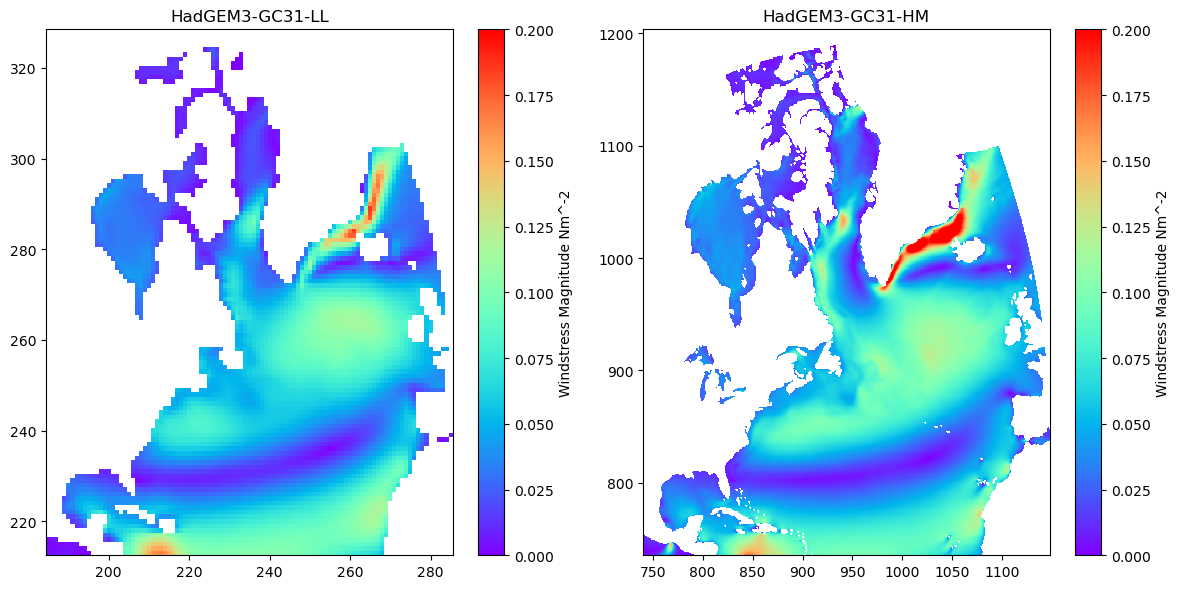

In [11]:
import matplotlib.pyplot as plt

# Assuming data1 and data2 are the provided xarray DataArrays
data_arrays = magnitudes
titles = source_ids

vmin = 0
vmax = 0.2

# Create figure
fig = plt.figure(figsize=(12, 6))

# Loop through the data arrays and plot each using subplot2grid
for i, data in enumerate(data_arrays):
    ax = plt.subplot2grid((1, 2), (0, i))  # Define subplot position in grid
    pcm = ax.pcolormesh(data.j, data.i, data,
                        vmin=vmin, vmax=vmax,
                        cmap="rainbow", shading="auto")
    ax.set_title(titles[i])
    fig.colorbar(pcm, ax=ax, orientation="vertical", label="Windstress Magnitude Nm^-2")
    #ax.add_feature(cfeature.LAND.with_scale('110m'),zorder=4)
    #ax.add_feature(cfeature.COASTLINE, edgecolor="black",zorder=4)

# Adjust layout
plt.tight_layout()
plt.show()


In [12]:
%%time

from dask.diagnostics import ProgressBar

models_mdt_cons_u=[]
models_shelf_mdt_cons_u=[]

models_mdt_cons_v=[]
models_shelf_mdt_cons_v=[]

regrid_size = 1.0
destgrid = generate_global_grid(regrid_size)

ds_bathy = xr.open_dataset(inputdir+"/obs/GEBCO.nc")
ds_bathy= cutdomain(ds_bathy, margin)
regrddr = xe.Regridder(ds_bathy, destgrid, "conservative",ignore_degenerate=True)
depth = regrddr(ds_bathy.depth,skipna=True, na_thres=1)

dmask=(depth>-1000)

# Enable Dask's progress bar
pbar = ProgressBar()
pbar.register()

for i in range(len(source_ids)):
# for i in [4]:
    ds_model_u= ds_models_tauu[i].compute()
    ds_model_v= ds_models_tauv[i].compute()

    #ds_model_u = ds_model_u.chunk(dict(i=-1))  # Rechunk along 'i' to have a single chunk
    #ds_model_v = ds_model_v.chunk(dict(i=-1))

    #if (source_ids[i]=="DTU22"):
    #    regrddr = xe.Regridder(ds_model, destgrid, "conservative",ignore_degenerate=True)
    #    temp = regrddr(models_mdt[i],skipna=True, na_thres=1)
    #    model_mdt_cons = temp
    #    dtu_mdt = model_mdt_cons
    
    lat_corners_u = cfxr.bounds_to_vertices(ds_model_u.vertices_latitude, "vertices", order=None)
    lon_corners_u = cfxr.bounds_to_vertices(ds_model_u.vertices_longitude, "vertices", order=None)
    temp = ds_model_u.assign(lon_b=lon_corners_u, lat_b=lat_corners_u)
    regrddr = xe.Regridder(temp, destgrid, "conservative",ignore_degenerate=True)#,parallel=True)
    temp = regrddr(ds_models_tauu[i],skipna=True, na_thres=1)   
    model_mdt_cons_u = temp#-dtu_mdt

    lat_corners_v = cfxr.bounds_to_vertices(ds_model_v.vertices_latitude, "vertices", order=None)
    lon_corners_v = cfxr.bounds_to_vertices(ds_model_v.vertices_longitude, "vertices", order=None)
    temp = ds_model_v.assign(lon_b=lon_corners_v, lat_b=lat_corners_v)
    regrddr = xe.Regridder(temp, destgrid, "conservative",ignore_degenerate=True)#,parallel=True)
    temp = regrddr(ds_models_tauv[i],skipna=True, na_thres=1)   
    model_mdt_cons_v = temp#-dtu_mdt
        
    models_shelf_mdt_cons_u.append(dmask*model_mdt_cons_u)        
    models_mdt_cons_u.append(model_mdt_cons_u)

    models_shelf_mdt_cons_v.append(dmask*model_mdt_cons_v)        
    models_mdt_cons_v.append(model_mdt_cons_v)
    
    print('Done with ' + source_ids[i])
# models_mdt_cons

/glade/u/home/netige/miniconda3/envs/_MDTF_python3_base/lib/python3.12/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


[########################################] | 100% Completed | 3.26 sms
[########################################] | 100% Completed | 3.96 sms
Done with HadGEM3-GC31-LL
[########################################] | 100% Completed | 55.01 s
[########################################] | 100% Completed | 61.02 s
Done with HadGEM3-GC31-HM
CPU times: user 2min 7s, sys: 6.84 s, total: 2min 14s
Wall time: 2min 38s


In [19]:
magnitudes_cons = []

for i in range(len(source_ids)):
    tauu = models_mdt_cons_u[i].tauuo
    tauv = models_mdt_cons_v[i].tauvo

    # Compute derived variables
    magnitude = np.sqrt(tauu**2 + tauv**2)

    magnitudes_cons.append(magnitude)
    
    print('Done with ' + source_ids[i])

Done with HadGEM3-GC31-LL
Done with HadGEM3-GC31-HM


[########################################] | 100% Completed | 946.21 ms
[########################################] | 100% Completed | 22.85 s


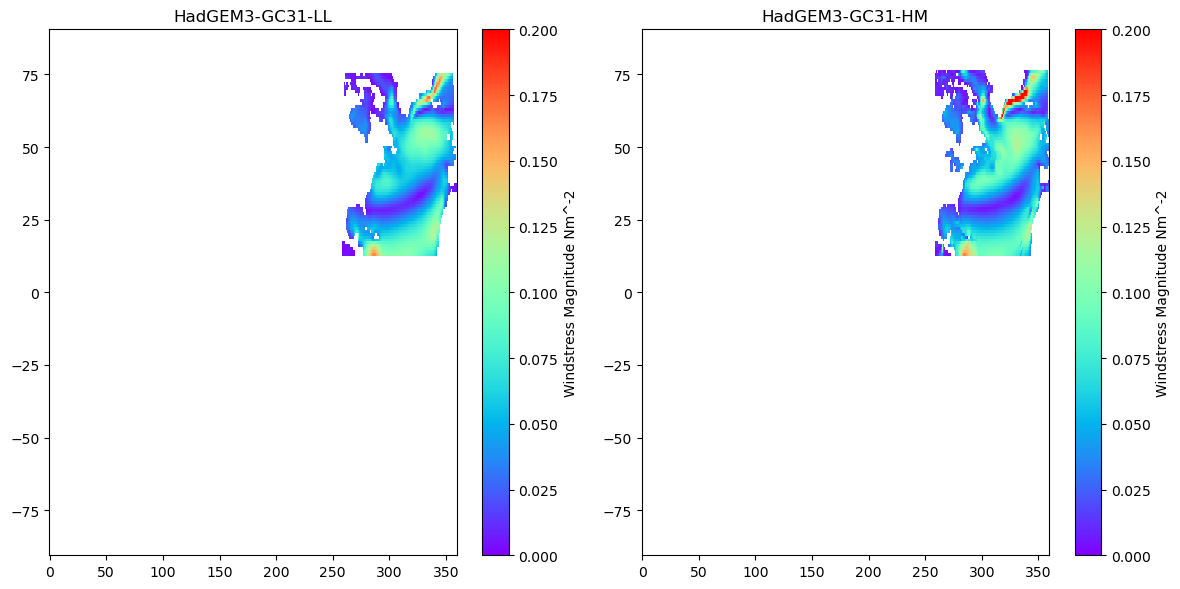

In [20]:
import matplotlib.pyplot as plt

# Assuming data1 and data2 are the provided xarray DataArrays
data_arrays = magnitudes_cons
titles = source_ids

vmin = 0
vmax = 0.2

# Create figure
fig = plt.figure(figsize=(12, 6))

# Loop through the data arrays and plot each using subplot2grid
for i, data in enumerate(data_arrays):
    ax = plt.subplot2grid((1, 2), (0, i))  # Define subplot position in grid
    pcm = ax.pcolormesh(data.lon, data.lat, data,
                        vmin=vmin, vmax=vmax,
                        cmap="rainbow", shading="auto")
    ax.set_title(titles[i])
    fig.colorbar(pcm, ax=ax, orientation="vertical", label="Windstress Magnitude Nm^-2")
    #ax.add_feature(cfeature.LAND.with_scale('110m'),zorder=4)
    #ax.add_feature(cfeature.COASTLINE, edgecolor="black",zorder=4)

# Adjust layout
plt.tight_layout()
plt.show()


[########################################] | 100% Completed | 836.39 ms
[########################################] | 100% Completed | 832.73 ms
[                                        ] | 0% Completed | 229.98 us

/glade/derecho/scratch/netige/tmp/ipykernel_69313/3656680222.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['{}°E'.format(lon) for lon in range(120, 181, 10)])
/glade/derecho/scratch/netige/tmp/ipykernel_69313/3656680222.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{}°N'.format(lat) for lat in range(20, 51, 10)])


[########################################] | 100% Completed | 21.28 s
[########################################] | 100% Completed | 19.96 s


/glade/derecho/scratch/netige/tmp/ipykernel_69313/3656680222.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['{}°E'.format(lon) for lon in range(120, 181, 10)])
/glade/derecho/scratch/netige/tmp/ipykernel_69313/3656680222.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{}°N'.format(lat) for lat in range(20, 51, 10)])
/glade/derecho/scratch/netige/tmp/ipykernel_69313/3656680222.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


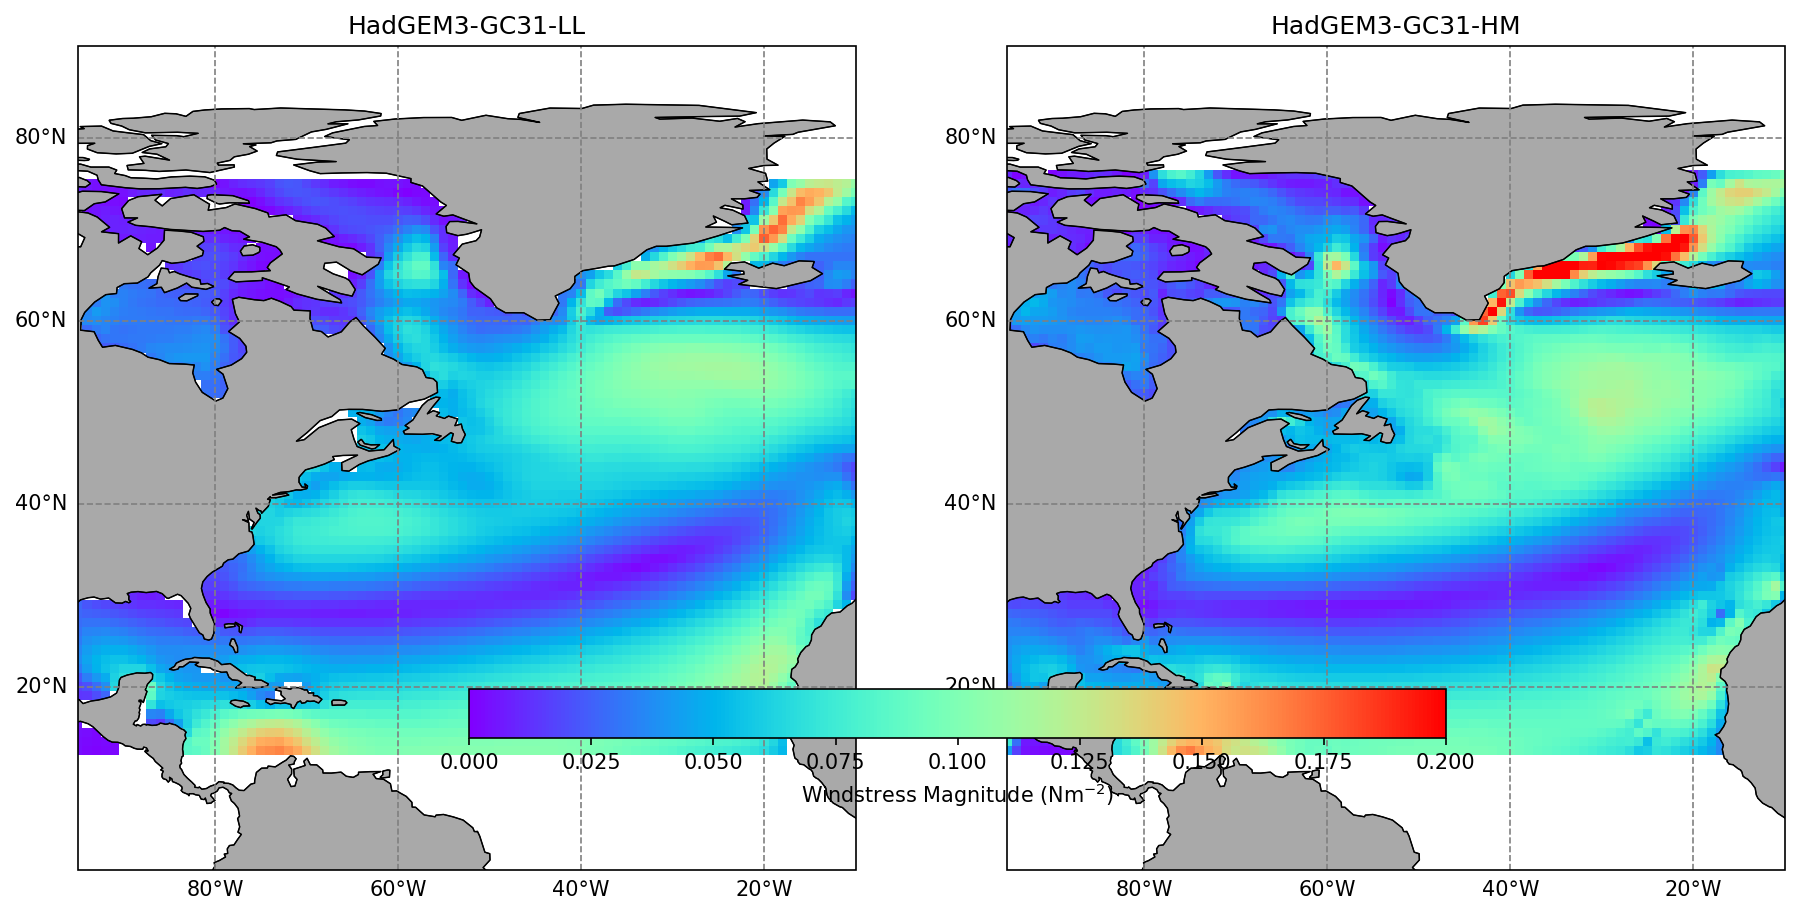

In [21]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Assuming data1 and data2 are the provided xarray DataArrays
data_arrays = magnitudes_cons  # Replace with your actual dataset
titles = source_ids[:2]  # First two source IDs for the two panels

vmin, vmax = 0, 0.2  # Define color scale limits

# Create figure and define subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(14, 6), dpi=150, 
                         subplot_kw={'projection': ccrs.PlateCarree(central_longitude=200.0)})

# Loop through both subplots
for i, ax in enumerate(axes):
    plotdata = data_arrays[i]  # Select corresponding dataset
    
    # Plot wind stress magnitude
    pc = ax.pcolormesh(plotdata.lon, plotdata.lat, plotdata, 
                       transform=ccrs.PlateCarree(), cmap="rainbow",
                       vmin=vmin, vmax=vmax, shading="auto")

    # Set map extent (focus on North Atlantic)
    ax.set_extent([-95, -10, 0, 90], crs=ccrs.PlateCarree())

    # Add gridlines and labels
    gl = ax.gridlines(color="gray", linestyle="dashed", draw_labels=True)
    gl.right_labels = False
    gl.top_labels = False

    # Set latitude/longitude tick labels
    #ax.set_xticks(range(120, 181, 10), crs=ccrs.PlateCarree())
    #ax.set_yticks(range(20, 51, 10), crs=ccrs.PlateCarree())
    ax.set_xticklabels(['{}°E'.format(lon) for lon in range(120, 181, 10)])
    ax.set_yticklabels(['{}°N'.format(lat) for lat in range(20, 51, 10)])

    # Add land mask and coastlines
    land = ax.add_feature(
        cfeature.NaturalEarthFeature("physical", "land", "110m",
                                     linewidth=0.5, edgecolor="black", facecolor="darkgray"))
    ax.add_feature(cfeature.COASTLINE, edgecolor="black", linewidth=0.7)

    # Set title
    ax.set_title(titles[i], fontsize=12)

# Add a single colorbar for both plots
cbar = fig.colorbar(pc, ax=axes.ravel().tolist(), orientation="horizontal", shrink=0.6)
cbar.set_label("Windstress Magnitude (Nm$^{-2}$)")

# Show plot
plt.tight_layout()
plt.show()


[########################################] | 100% Completed | 932.53 ms
[########################################] | 100% Completed | 825.98 ms
[########################################] | 100% Completed | 18.61 s
[########################################] | 100% Completed | 17.20 s
[########################################] | 100% Completed | 19.73 s
[########################################] | 100% Completed | 19.64 s


/glade/derecho/scratch/netige/tmp/ipykernel_69313/2535286941.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


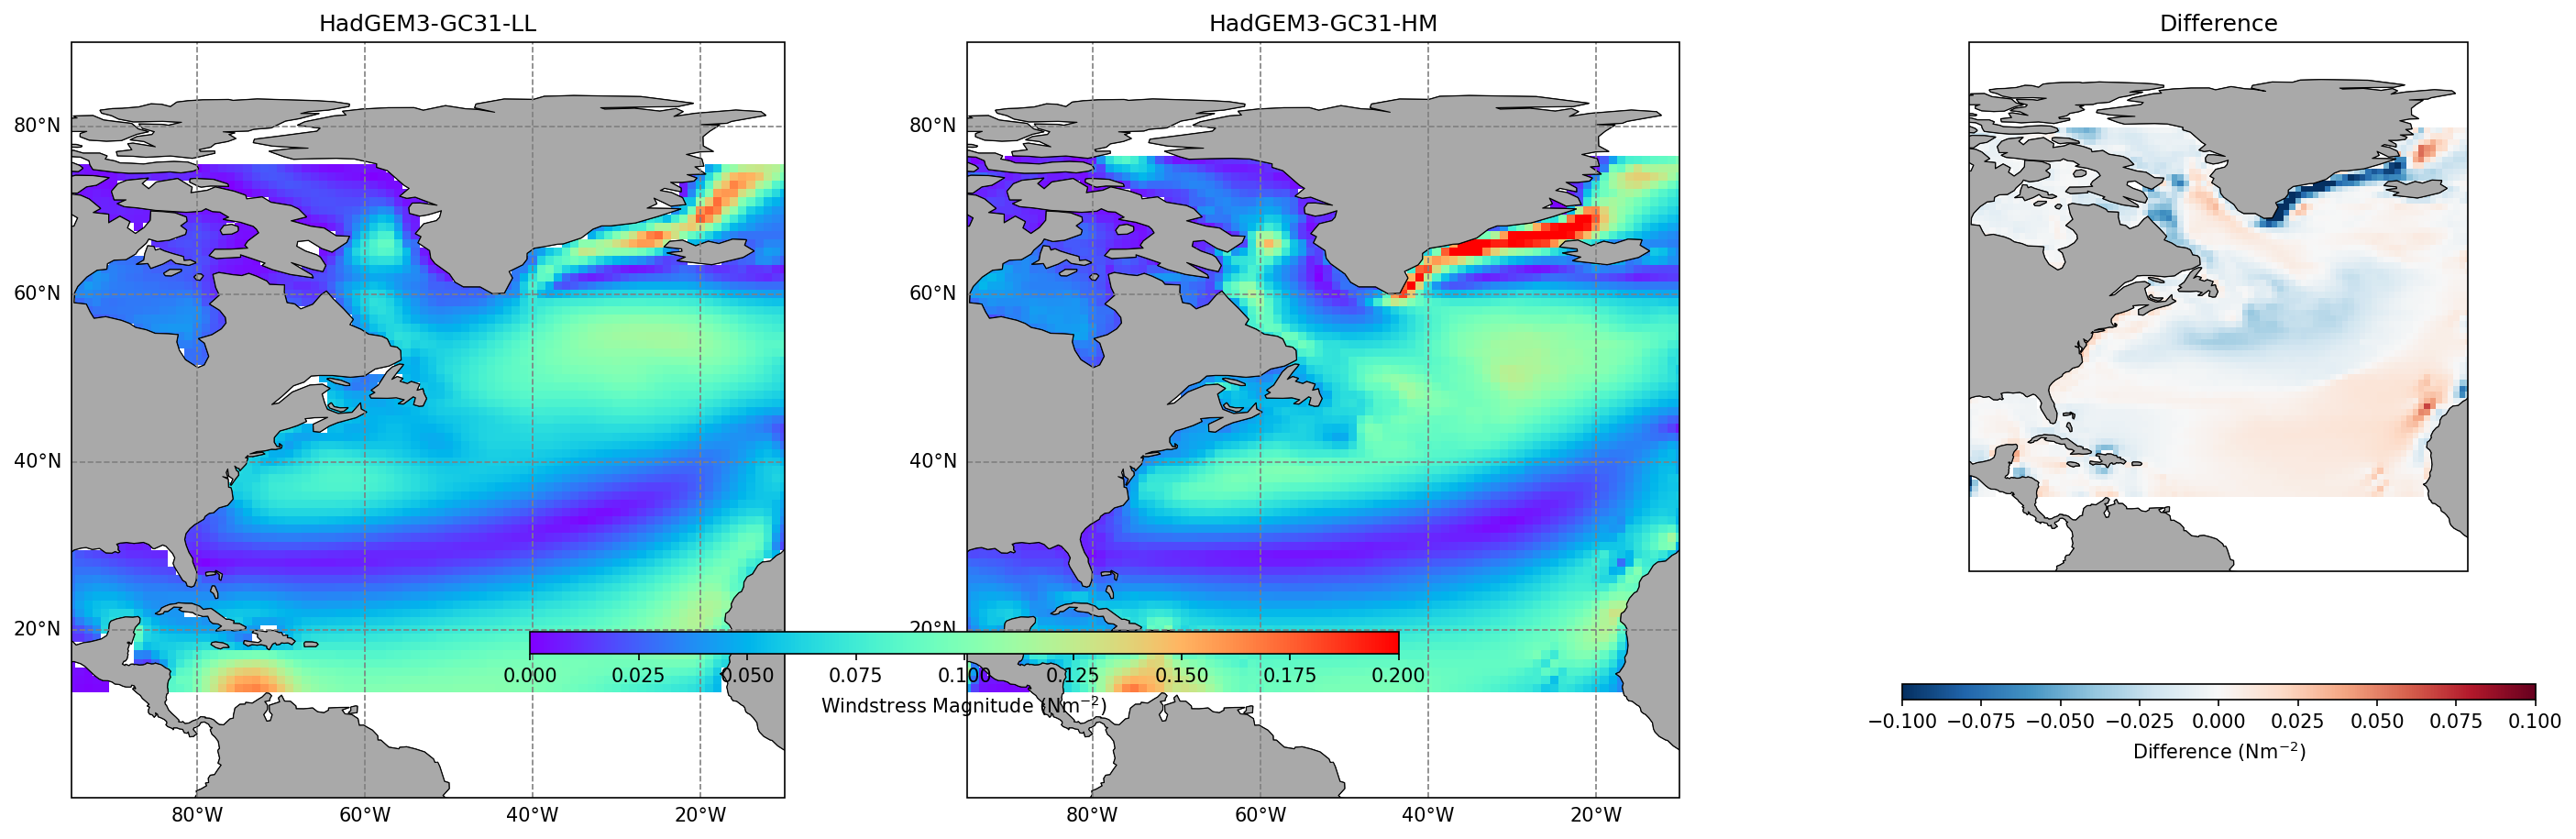

In [22]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# Assuming data1 and data2 are the provided xarray DataArrays
data_arrays = magnitudes_cons  # Replace with your actual dataset
titles = source_ids[:2] + ["Difference"]  # First two source IDs and difference panel

vmin, vmax = 0, 0.2  # Define color scale limits for first two panels
diff_vmin, diff_vmax = -0.1, 0.1  # Define color scale limits for difference panel

# Create figure and define subplots (1 row, 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(21, 6), dpi=150, 
                         subplot_kw={'projection': ccrs.PlateCarree(central_longitude=200.0)})

# Loop through first two panels
for i, ax in enumerate(axes[:2]):
    plotdata = data_arrays[i]  # Select corresponding dataset
    
    # Plot wind stress magnitude
    pc = ax.pcolormesh(plotdata.lon, plotdata.lat, plotdata, 
                       transform=ccrs.PlateCarree(), cmap="rainbow",
                       vmin=vmin, vmax=vmax, shading="auto")

    # Set map extent (focus on North Atlantic)
    ax.set_extent([-95, -10, 0, 90], crs=ccrs.PlateCarree())

    # Add gridlines and labels
    gl = ax.gridlines(color="gray", linestyle="dashed", draw_labels=True)
    gl.right_labels = False
    gl.top_labels = False
    
    # Add land mask and coastlines
    ax.add_feature(cfeature.COASTLINE, edgecolor="black", linewidth=0.7)
    ax.add_feature(cfeature.NaturalEarthFeature("physical", "land", "110m",
                                     linewidth=0.5, edgecolor="black", facecolor="darkgray"))
    
    # Set title
    ax.set_title(titles[i], fontsize=12)

# Compute difference between first two datasets
diff_data = data_arrays[0] - data_arrays[1]

# Plot third panel with difference
pc_diff = axes[2].pcolormesh(diff_data.lon, diff_data.lat, diff_data, 
                             transform=ccrs.PlateCarree(), cmap="RdBu_r",
                             vmin=diff_vmin, vmax=diff_vmax, shading="auto")

axes[2].set_extent([-95, -10, 0, 90], crs=ccrs.PlateCarree())
axes[2].add_feature(cfeature.COASTLINE, edgecolor="black", linewidth=0.7)
axes[2].add_feature(cfeature.NaturalEarthFeature("physical", "land", "110m",
                                     linewidth=0.5, edgecolor="black", facecolor="darkgray"))
axes[2].set_title(titles[2], fontsize=12)

# Add colorbars
cbar = fig.colorbar(pc, ax=axes[:2], orientation="horizontal", shrink=0.6, aspect=40)
cbar.set_label("Windstress Magnitude (Nm$^{-2}$)")

cbar_diff = fig.colorbar(pc_diff, ax=axes[2], orientation="horizontal", shrink=0.6, aspect=40)
cbar_diff.set_label("Difference (Nm$^{-2}$)")

# Show plot
plt.tight_layout()
plt.show()


[########################################] | 100% Completed | 835.99 ms
[########################################] | 100% Completed | 949.19 ms
[########################################] | 100% Completed | 22.92 s
[########################################] | 100% Completed | 19.53 s
[########################################] | 100% Completed | 18.29 s
[########################################] | 100% Completed | 18.42 s


/glade/derecho/scratch/netige/tmp/ipykernel_69313/2535286941.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


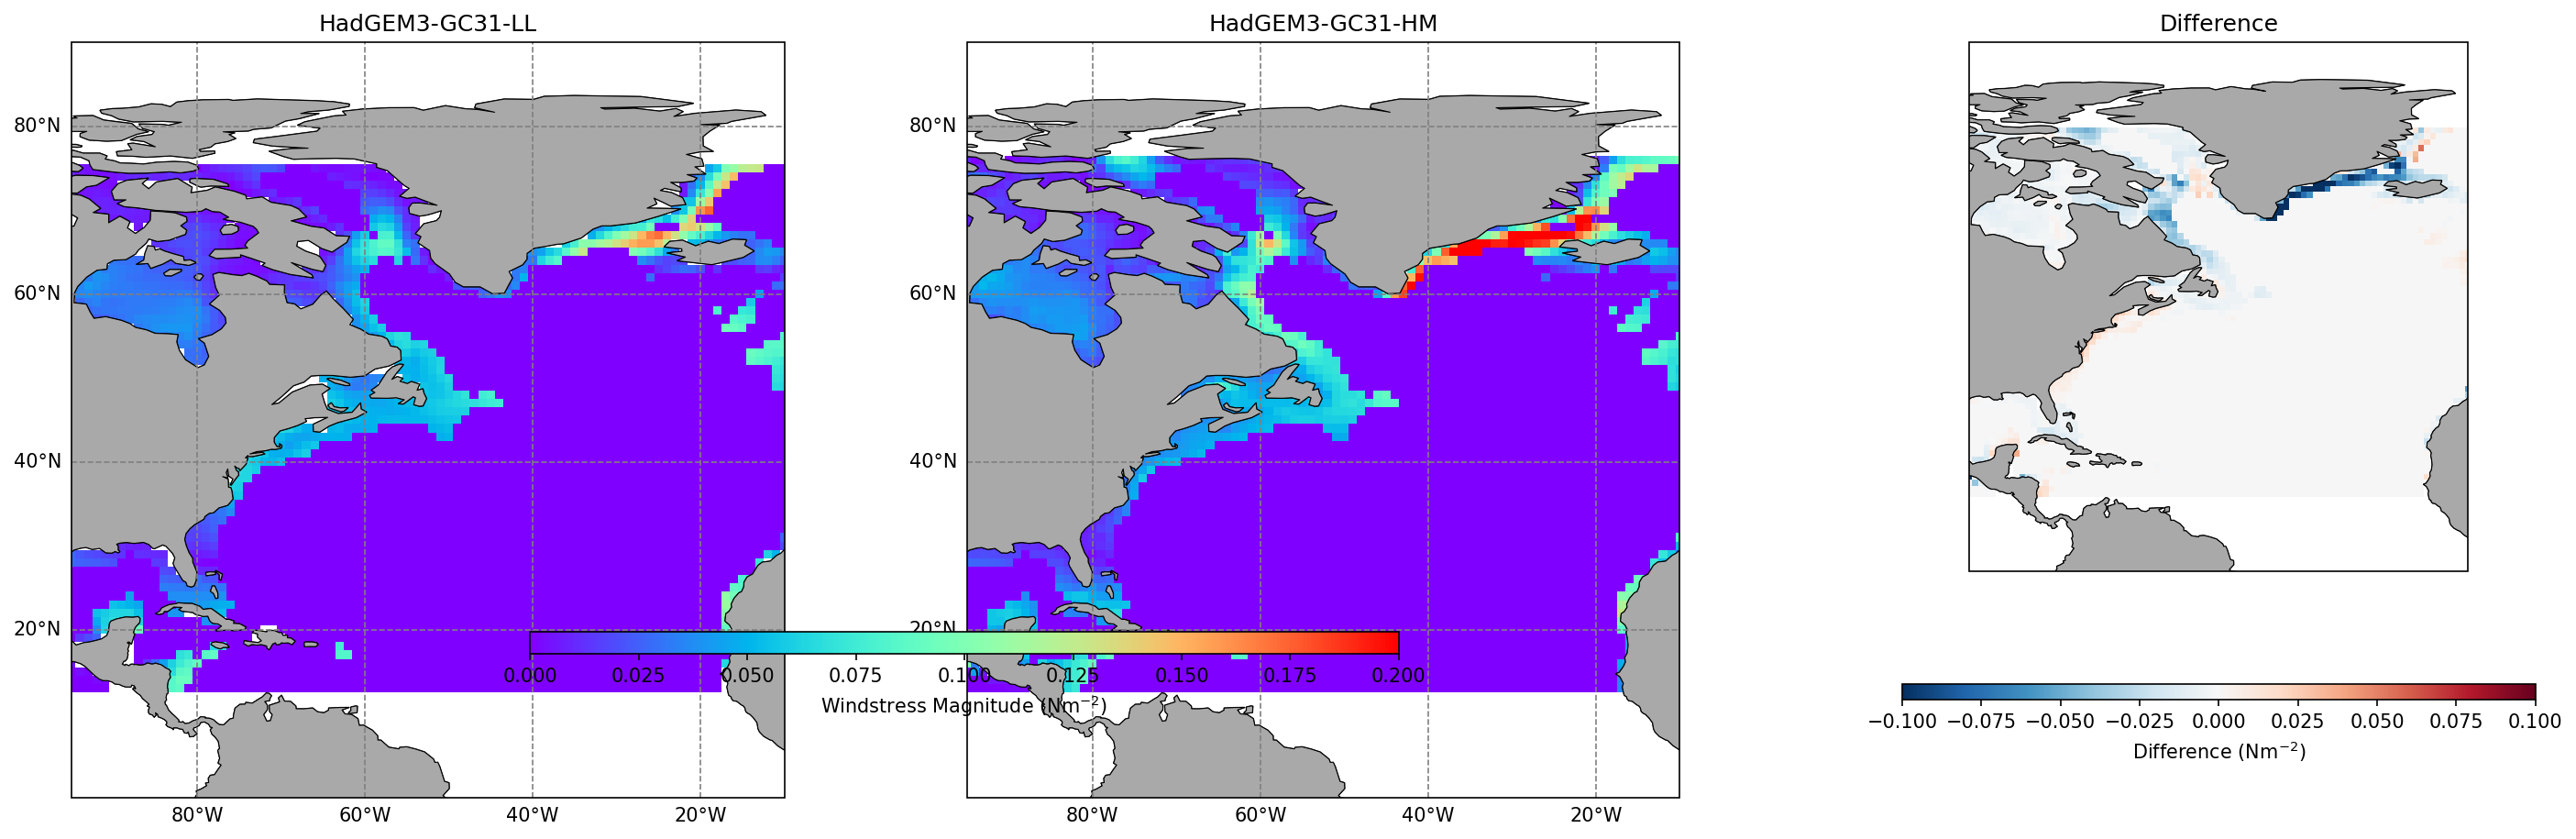

In [17]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# Assuming data1 and data2 are the provided xarray DataArrays
data_arrays = magnitudes_cons  # Replace with your actual dataset
titles = source_ids[:2] + ["Difference"]  # First two source IDs and difference panel

vmin, vmax = 0, 0.2  # Define color scale limits for first two panels
diff_vmin, diff_vmax = -0.1, 0.1  # Define color scale limits for difference panel

# Create figure and define subplots (1 row, 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(21, 6), dpi=150, 
                         subplot_kw={'projection': ccrs.PlateCarree(central_longitude=200.0)})

# Loop through first two panels
for i, ax in enumerate(axes[:2]):
    plotdata = data_arrays[i]  # Select corresponding dataset
    
    # Plot wind stress magnitude
    pc = ax.pcolormesh(plotdata.lon, plotdata.lat, plotdata, 
                       transform=ccrs.PlateCarree(), cmap="rainbow",
                       vmin=vmin, vmax=vmax, shading="auto")

    # Set map extent (focus on North Atlantic)
    ax.set_extent([-95, -10, 0, 90], crs=ccrs.PlateCarree())

    # Add gridlines and labels
    gl = ax.gridlines(color="gray", linestyle="dashed", draw_labels=True)
    gl.right_labels = False
    gl.top_labels = False
    
    # Add land mask and coastlines
    ax.add_feature(cfeature.COASTLINE, edgecolor="black", linewidth=0.7)
    ax.add_feature(cfeature.NaturalEarthFeature("physical", "land", "110m",
                                     linewidth=0.5, edgecolor="black", facecolor="darkgray"))
    
    # Set title
    ax.set_title(titles[i], fontsize=12)

# Compute difference between first two datasets
diff_data = data_arrays[0] - data_arrays[1]

# Plot third panel with difference
pc_diff = axes[2].pcolormesh(diff_data.lon, diff_data.lat, diff_data, 
                             transform=ccrs.PlateCarree(), cmap="RdBu_r",
                             vmin=diff_vmin, vmax=diff_vmax, shading="auto")

axes[2].set_extent([-95, -10, 0, 90], crs=ccrs.PlateCarree())
axes[2].add_feature(cfeature.COASTLINE, edgecolor="black", linewidth=0.7)
axes[2].add_feature(cfeature.NaturalEarthFeature("physical", "land", "110m",
                                     linewidth=0.5, edgecolor="black", facecolor="darkgray"))
axes[2].set_title(titles[2], fontsize=12)

# Add colorbars
cbar = fig.colorbar(pc, ax=axes[:2], orientation="horizontal", shrink=0.6, aspect=40)
cbar.set_label("Windstress Magnitude (Nm$^{-2}$)")

cbar_diff = fig.colorbar(pc_diff, ax=axes[2], orientation="horizontal", shrink=0.6, aspect=40)
cbar_diff.set_label("Difference (Nm$^{-2}$)")

# Show plot
plt.tight_layout()
plt.show()


In [11]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# Load the datasets (assuming they are already opened)
#ds_LL = ...  # Load HadGEM3-GC31-LL dataset
#ds_HH = ...  # Load HadGEM3-GC31-HH dataset

# Extract variables
tauu_LL = models_shelf_mdt_cons_u[0].tauuo
tauv_LL = models_shelf_mdt_cons_v[0].tauvo
tauu_HH = models_shelf_mdt_cons_u[1].tauuo
tauv_HH = models_shelf_mdt_cons_v[1].tauvo

lat_LL, lon_LL = tauu_LL['lat'], tauu_LL['lon']
lat_HH, lon_HH = tauu_HH['lat'], tauu_HH['lon']

# Compute derived variables
tau_magnitude_LL = np.sqrt(tauu_LL**2 + tauv_LL**2)
tau_magnitude_HH = np.sqrt(tauu_HH**2 + tauv_HH**2)
tau_magnitude_diff = tau_magnitude_LL - tau_magnitude_HH

# Compute curl (finite difference approximation)
dx_LL = np.gradient(lon_LL, axis=1)
dy_LL = np.gradient(lat_LL, axis=0)

dx_HH = np.gradient(lon_HH, axis=1)
dy_HH = np.gradient(lat_HH, axis=0)

curl_LL = (np.gradient(tauv_LL, axis=1) / dx_LL) - (np.gradient(tauu_LL, axis=0) / dy_LL)
curl_HH = (np.gradient(tauv_HH, axis=1) / dx_HH) - (np.gradient(tauu_HH, axis=0) / dy_HH)
curl_diff = curl_LL - curl_HH

# Create figure
fig, axes = plt.subplots(3, 3, figsize=(15, 15), constrained_layout=True)

# Titles
titles = [
    "Wind Stress Vectors - LL", "Wind Stress Vectors - HH", "Difference (LL - HH)",
    "Magnitude - LL", "Magnitude - HH", "Magnitude Difference",
    "Curl - LL", "Curl - HH", "Curl Difference"
]

# Plot vectors (row 1)
q1 = axes[0, 0].quiver(lon_LL, lat_LL, tauu_LL, tauv_LL, scale=10)
axes[0, 0].set_title(titles[0])
q2 = axes[0, 1].quiver(lon_HH, lat_HH, tauu_HH, tauv_HH, scale=10)
axes[0, 1].set_title(titles[1])
q3 = axes[0, 2].quiver(lon_LL, lat_LL, tauu_LL - tauu_HH, tauv_LL - tauv_HH, scale=10)
axes[0, 2].set_title(titles[2])

# Plot magnitude (row 2)
c1 = axes[1, 0].contourf(lon_LL, lat_LL, tau_magnitude_LL, cmap="plasma")
fig.colorbar(c1, ax=axes[1, 0])
axes[1, 0].set_title(titles[3])

c2 = axes[1, 1].contourf(lon_HH, lat_HH, tau_magnitude_HH, cmap="plasma")
fig.colorbar(c2, ax=axes[1, 1])
axes[1, 1].set_title(titles[4])

c3 = axes[1, 2].contourf(lon_LL, lat_LL, tau_magnitude_diff, cmap="RdBu_r")
fig.colorbar(c3, ax=axes[1, 2])
axes[1, 2].set_title(titles[5])

# Plot curl (row 3)
c4 = axes[2, 0].contourf(lon_LL, lat_LL, curl_LL, cmap="RdBu_r")
fig.colorbar(c4, ax=axes[2, 0])
axes[2, 0].set_title(titles[6])

c5 = axes[2, 1].contourf(lon_HH, lat_HH, curl_HH, cmap="RdBu_r")
fig.colorbar(c5, ax=axes[2, 1])
axes[2, 1].set_title(titles[7])

c6 = axes[2, 2].contourf(lon_LL, lat_LL, curl_diff, cmap="coolwarm")
fig.colorbar(c6, ax=axes[2, 2])
axes[2, 2].set_title(titles[8])

# Show figure
plt.show()


AxisError: axis 1 is out of bounds for array of dimension 1

ValueError: Argument V has a size 11832 which does not match 11817, the number of arrow positions

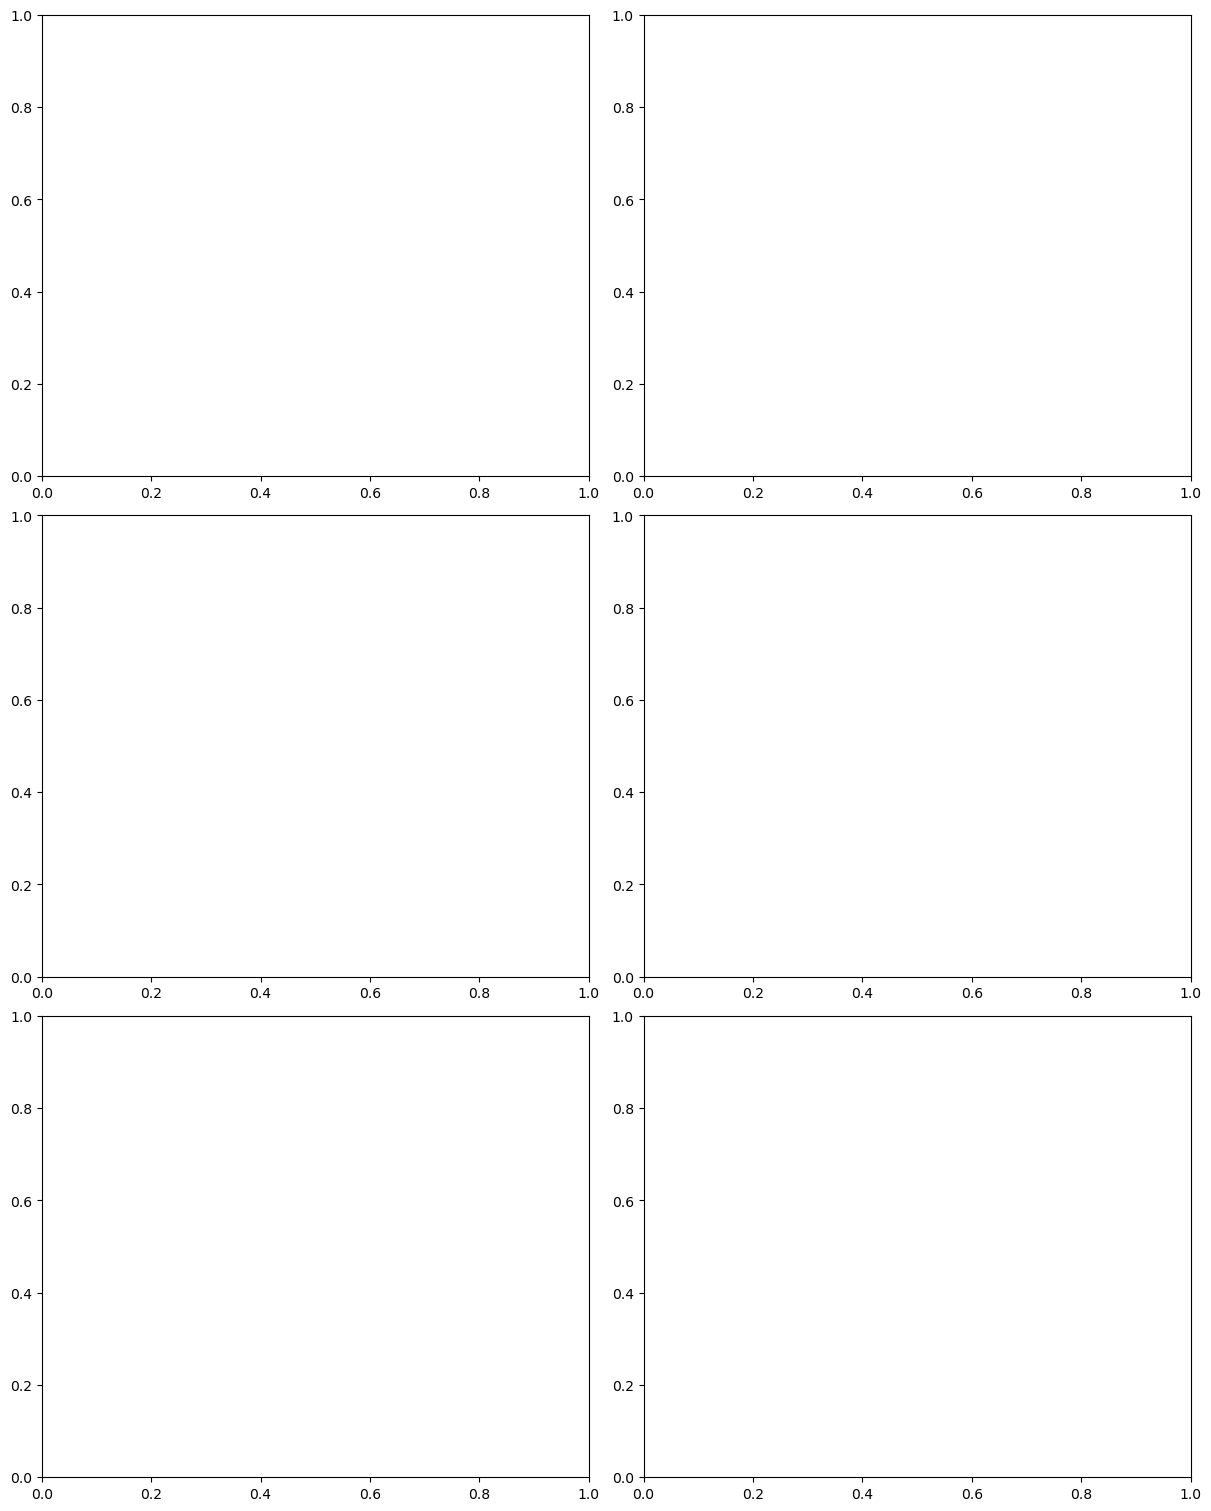

In [25]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# Extract variables
tauu_LL = ds_models_tauu[0].tauuo
tauv_LL = ds_models_tauv[0].tauvo
tauu_HH = ds_models_tauu[1].tauuo
tauv_HH = ds_models_tauv[1].tauvo

lat_LL, lon_LL = tauu_LL['latitude'], tauu_LL['longitude']
lat_HH, lon_HH = tauu_HH['latitude'], tauu_HH['longitude']

# Compute derived variables
tau_magnitude_LL = np.sqrt(tauu_LL**2 + tauv_LL**2)
tau_magnitude_HH = np.sqrt(tauu_HH**2 + tauv_HH**2)
tau_magnitude_diff = tau_magnitude_LL - tau_magnitude_HH

# Create figure (3 rows, 2 columns)
fig, axes = plt.subplots(3, 2, figsize=(12, 15), constrained_layout=True)

# Titles
titles = [
    "Wind Stress Vectors - LL", "Wind Stress Vectors - HH",
    "Difference (LL - HH)", "Magnitude - LL",
    "Magnitude - HH", "Magnitude Difference"
]

# Plot vectors (row 1)
q1 = axes[0, 0].quiver(lon_LL, lat_LL, tauu_LL, tauv_LL, scale=10)
axes[0, 0].set_title(titles[0])

q2 = axes[0, 1].quiver(lon_HH, lat_HH, tauu_HH, tauv_HH, scale=10)
axes[0, 1].set_title(titles[1])

# Plot vector difference (row 2)
q3 = axes[1, 0].quiver(lon_LL, lat_LL, tauu_LL - tauu_HH, tauv_LL - tauv_HH, scale=10)
axes[1, 0].set_title(titles[2])

# Plot magnitude (row 3)
c1 = axes[1, 1].contourf(lon_LL, lat_LL, tau_magnitude_LL, cmap="plasma")
fig.colorbar(c1, ax=axes[1, 1])
axes[1, 1].set_title(titles[3])

c2 = axes[2, 0].contourf(lon_HH, lat_HH, tau_magnitude_HH, cmap="plasma")
fig.colorbar(c2, ax=axes[2, 0])
axes[2, 0].set_title(titles[4])

c3 = axes[2, 1].contourf(lon_LL, lat_LL, tau_magnitude_diff, cmap="RdBu_r")
fig.colorbar(c3, ax=axes[2, 1])
axes[2, 1].set_title(titles[5])

# Show figure
plt.show()


In [26]:
print("tauu_LL shape:", tauu_LL.shape)
print("tauv_LL shape:", tauv_LL.shape)
print("lon_LL shape:", lon_LL.shape)
print("lat_LL shape:", lat_LL.shape)



tauu_LL shape: (117, 101)
tauv_LL shape: (116, 102)
lon_LL shape: (117, 101)
lat_LL shape: (117, 101)


In [34]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# Extract variables
tauu_LL = ds_models_tauu[0].tauuo
tauv_LL = ds_models_tauv[0].tauvo
tauu_HH = ds_models_tauu[1].tauuo
tauv_HH = ds_models_tauv[1].tauvo

lat_LL, lon_LL = tauu_LL['latitude'], tauu_LL['longitude']
lat_HH, lon_HH = tauu_HH['latitude'], tauu_HH['longitude']

# Align shapes
#tauv_LL = tauv_LL.isel(latitude=slice(0, 117), longitude=slice(0, 101))  # Trim tauv_LL
#tauv_HH = tauv_HH.isel(latitude=slice(0, tauu_HH.shape[0]), longitude=slice(0, tauu_HH.shape[1]))  # Trim HH

# Compute derived variables
tau_magnitude_LL = np.sqrt(tauu_LL**2 + tauv_LL**2)
tau_magnitude_HH = np.sqrt(tauu_HH**2 + tauv_HH**2)
tau_magnitude_diff = tau_magnitude_LL - tau_magnitude_HH




[########################################] | 100% Completed | 1.04 sms


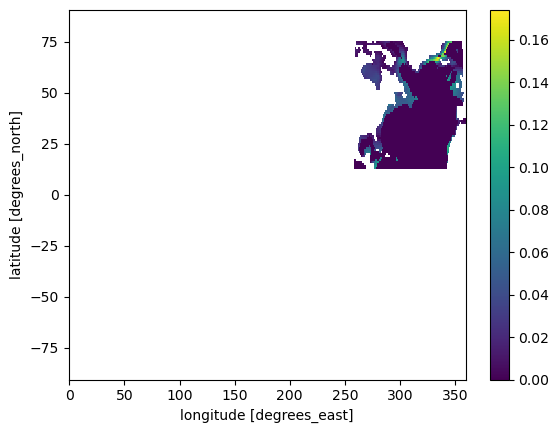

In [16]:
tau_magnitude_LL.plot()

[########################################] | 100% Completed | 18.65 s


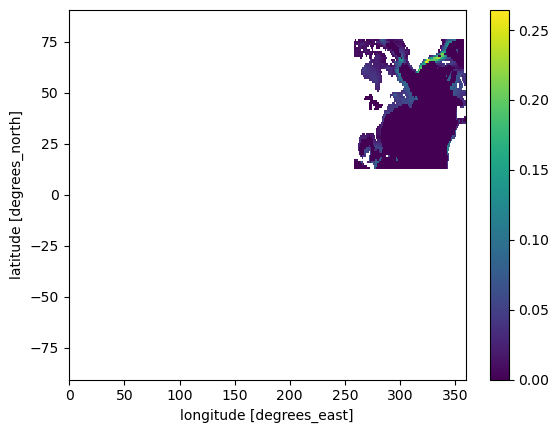

In [17]:
tau_magnitude_HH.plot()

In [18]:
%%time
pc = []
axes = []
fig = plt.figure(figsize=(10, 16))


bias_diff=[]
indic=np.argsort(RMSE[lrlist])
for i in np.arange(len(lrlist)):
    nmod=lrlist[indic[i]]
    print(nmod)
    tt=((models_mdt_cons[nmod])-(models_mdt_cons[nmod+1]))
    bias_diff.append(tt)

    ax = plt.subplot2grid((5,2), (i,0), colspan=1, rowspan=1, projection=ccrs.PlateCarree(),aspect="auto")
    vmin = -0.8
    vmax = .5
    pos = ax.get_position() # get the original position 
    plotdata = models_mdt_cons[nmod+1]
    p=plt.pcolormesh(plotdata.lon ,plotdata.lat, plotdata,
                     vmin=vmin, vmax=vmax, 
                     cmap='gist_ncar',
                     zorder=1,
                     transform=ccrs.PlateCarree())
    CS2 = ax.contour(plotdata.lon ,plotdata.lat, -depth,
                    np.arange(0,500,100),colors='k',linewidths=2,zorder=2,transform=ccrs.PlateCarree())
    CS2 = ax.contour(plotdata.lon ,plotdata.lat, plotdata,
                    np.arange(0,1,1),colors='.6',linewidths=2,zorder=2,transform=ccrs.PlateCarree())
    ax.set_extent([-100,-40,23,70], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND.with_scale('110m'),zorder=4)
    ax.add_feature(cfeature.COASTLINE, edgecolor="black",zorder=4) 
    ax.add_feature(cfeature.STATES, edgecolor="black",zorder=4) 
    ax.set_title(source_ids[nmod+1],loc='center')

    if i==4:
        cbar_ax = fig.add_axes(
            [pos.x0, pos.y0-(pos.y1 - pos.y0) / 10, (pos.x1 - pos.x0), (pos.y1 - pos.y0)/15]
        )
        cbar = fig.colorbar(p, orientation="horizontal", cax=cbar_ax, extend="both")
        cbar.ax.tick_params(labelsize=8)
        cbar.set_label('MDSL HR')  # Example label, adjust as needed

    # ax = plt.subplot2grid((5,3), (i,1), colspan=1, rowspan=1, projection=ccrs.PlateCarree())
    # pos = ax.get_position() # get the original position 
    # plotdata = models_mdt_cons[nmod]
    # p=plt.pcolormesh(plotdata.lon ,plotdata.lat, plotdata,
    #                  vmin=vmin, vmax=vmax, 
    #                  cmap='RdBu_r',
    #                  zorder=1,
    #                  transform=ccrs.PlateCarree())
    # CS2 = ax.contour(plotdata.lon ,plotdata.lat, -depth,
    #                 np.arange(0,500,100),colors='k',linewidths=2,zorder=2,transform=ccrs.PlateCarree())
    # CS2 = ax.contour(plotdata.lon ,plotdata.lat, plotdata,
    #                 np.arange(0,1,1),colors='.6',linewidths=2,zorder=2,transform=ccrs.PlateCarree())
    # ax.set_extent([-100,-40,23,70], crs=ccrs.PlateCarree())
    # ax.add_feature(cfeature.LAND.with_scale('110m'),zorder=4)
    # ax.add_feature(cfeature.COASTLINE, edgecolor="black",zorder=4) 
    # ax.add_feature(cfeature.STATES, edgecolor="black",zorder=4) 
    # ax.set_title(source_ids[nmod],loc='center')

    # if i==4:
    #     cbar_ax = fig.add_axes(
    #         [pos.x0, pos.y0-(pos.y1 - pos.y0) / 10, (pos.x1 - pos.x0), (pos.y1 - pos.y0)/15]
    #     )
    #     cbar = fig.colorbar(p, orientation="horizontal", cax=cbar_ax, extend="both")
    #     cbar.ax.tick_params(labelsize=8)
    #     cbar.set_label('MDSL bias in LR (relative to NJ, m)')  # Example label, adjust as needed

    ax = plt.subplot2grid((5,2), (i,1), colspan=1, rowspan=1, projection=ccrs.PlateCarree(),aspect="auto")
    vmin = -0.3
    vmax = -vmin
    pos = ax.get_position() # get the original position 
    plotdata1=plotdata
    plotdata = bias_diff[i]
    p=plt.pcolormesh(plotdata.lon ,plotdata.lat, plotdata,
                     vmin=vmin, vmax=vmax, 
                     cmap='RdBu_r',
                     zorder=1,
                     transform=ccrs.PlateCarree())
    CS2 = ax.contour(plotdata.lon ,plotdata.lat, depth,
                    np.arange(-500,-400,100),colors='k',linewidths=2,zorder=2,transform=ccrs.PlateCarree())
    CS2 = ax.contour(plotdata.lon ,plotdata.lat, plotdata1,
                    np.arange(0,1,1),colors='.6',linewidths=2,zorder=2,transform=ccrs.PlateCarree())
    
    ax.set_extent([-100,-40,23,70], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND.with_scale('110m'),zorder=4)
    ax.add_feature(cfeature.COASTLINE, edgecolor="black",zorder=4) 
    ax.add_feature(cfeature.STATES, edgecolor="black",zorder=4) 
    ax.set_title('LR-HR diff',loc='center')

    if i==4:
        cbar_ax = fig.add_axes(
            [pos.x0, pos.y0-(pos.y1 - pos.y0) / 10, (pos.x1 - pos.x0), (pos.y1 - pos.y0)/15]
        )
        cbar = fig.colorbar(p, orientation="horizontal", cax=cbar_ax, extend="both")
        cbar.ax.tick_params(labelsize=8)
        cbar.set_label('LR-HR MDSL difference (m)')  # Example label, adjust as needed

plt.savefig('p1_f3.png',
)

NameError: name 'RMSE' is not defined

<Figure size 1000x1600 with 0 Axes>

In [43]:
print(tau_magnitude_HH.shape)
print(tau_magnitude_LL.shape)

(1405, 1223)
(116, 101)


[########################################] | 100% Completed | 827.74 ms
[########################################] | 100% Completed | 524.10 ms
[########################################] | 100% Completed | 10.07 ss
[########################################] | 100% Completed | 13.52 s
[########################################] | 100% Completed | 7.36 sms
[########################################] | 100% Completed | 12.54 s
[########################################] | 100% Completed | 938.21 ms
[########################################] | 100% Completed | 15.39 s
[########################################] | 100% Completed | 17.69 s


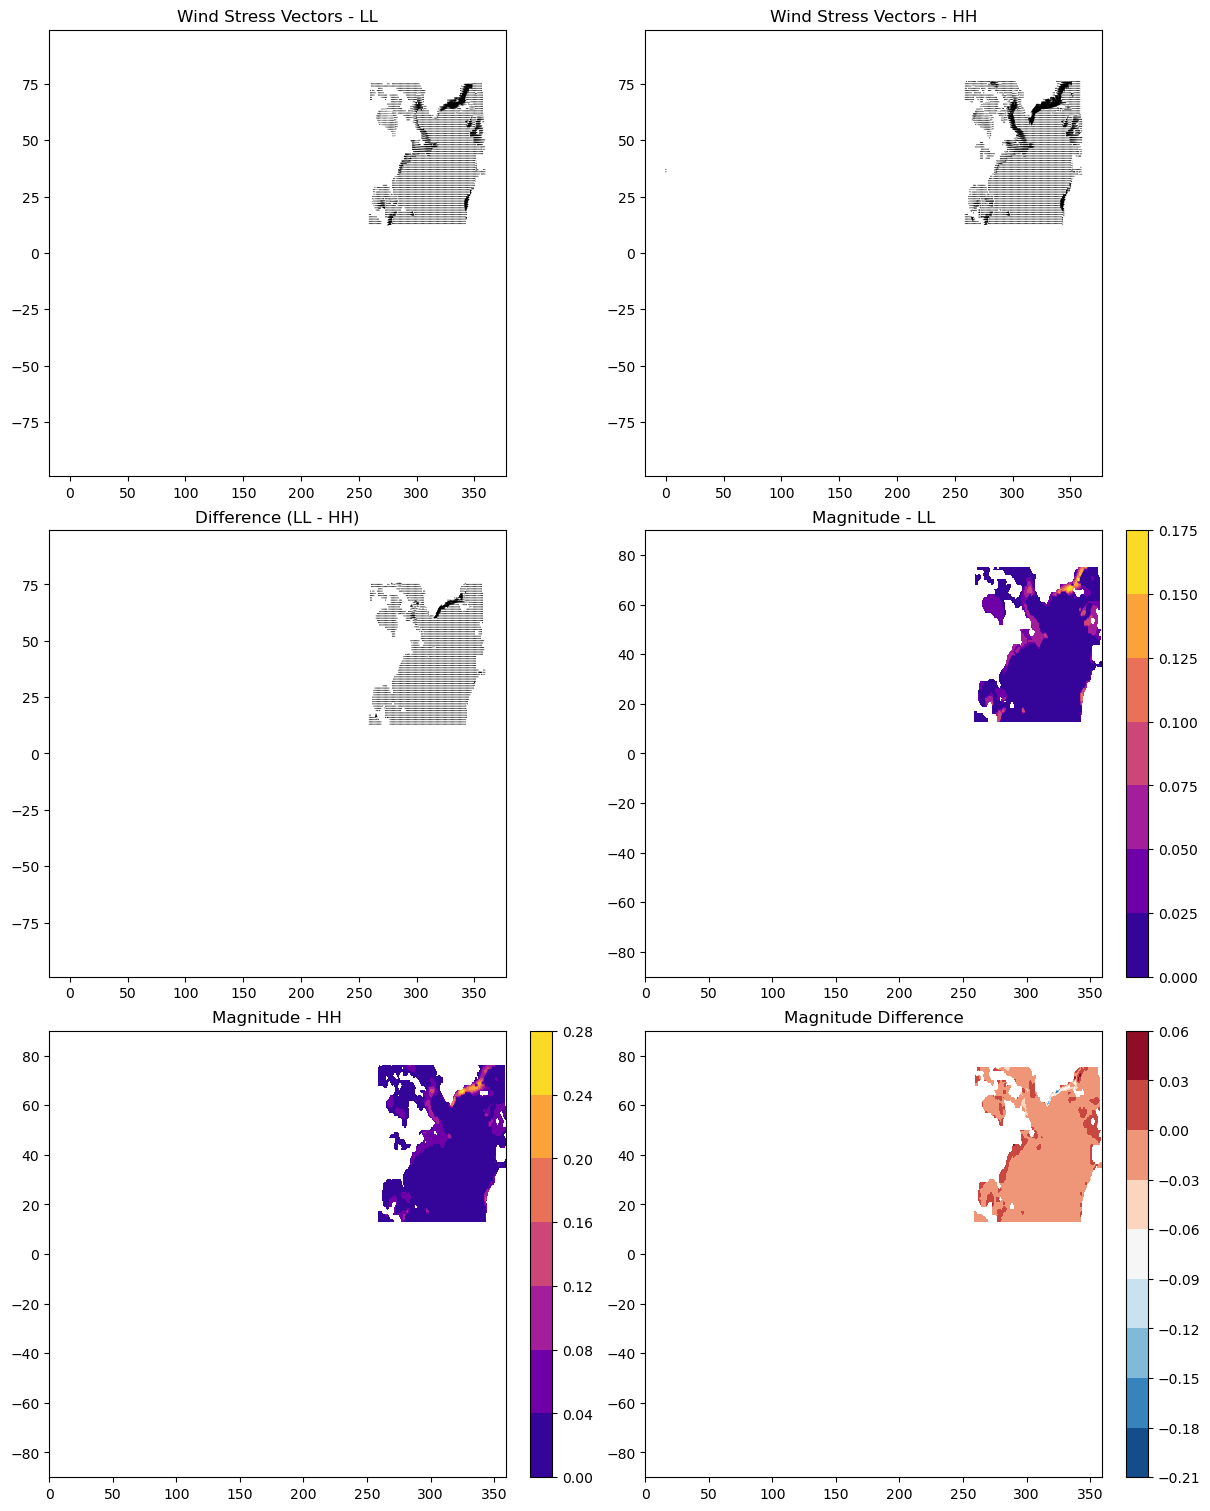

In [15]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# Extract variables
tauu_LL = models_shelf_mdt_cons_u[0].tauuo
tauv_LL = models_shelf_mdt_cons_v[0].tauvo
tauu_HH = models_shelf_mdt_cons_u[1].tauuo
tauv_HH = models_shelf_mdt_cons_v[1].tauvo

# Extract the correct coordinate names ('i', 'j') instead of ('latitude', 'longitude')
lat_LL, lon_LL = tauu_LL['lat'], tauu_LL['lon']
lat_HH, lon_HH = tauu_HH['lat'], tauu_HH['lon']

# Compute derived variables
tau_magnitude_LL = np.sqrt(tauu_LL**2 + tauv_LL**2)
tau_magnitude_HH = np.sqrt(tauu_HH**2 + tauv_HH**2)
tau_magnitude_diff = tau_magnitude_LL - tau_magnitude_HH

# Create figure (3 rows, 2 columns)
fig, axes = plt.subplots(3, 2, figsize=(12, 15), constrained_layout=True)

# Titles
titles = [
    "Wind Stress Vectors - LL", "Wind Stress Vectors - HH",
    "Difference (LL - HH)", "Magnitude - LL",
    "Magnitude - HH", "Magnitude Difference"
]

# Plot vectors (row 1)
q1 = axes[0, 0].quiver(lon_LL, lat_LL, tauu_LL, tauv_LL, scale=10)
axes[0, 0].set_title(titles[0])

q2 = axes[0, 1].quiver(lon_HH, lat_HH, tauu_HH, tauv_HH, scale=10)
axes[0, 1].set_title(titles[1])

# Plot vector difference (row 2)
q3 = axes[1, 0].quiver(lon_LL, lat_LL, tauu_LL - tauu_HH, tauv_LL - tauv_HH, scale=10)
axes[1, 0].set_title(titles[2])

# Plot magnitude (row 3)
c1 = axes[1, 1].contourf(lon_LL, lat_LL, tau_magnitude_LL, cmap="plasma")
fig.colorbar(c1, ax=axes[1, 1])
axes[1, 1].set_title(titles[3])

c2 = axes[2, 0].contourf(lon_HH, lat_HH, tau_magnitude_HH, cmap="plasma")
fig.colorbar(c2, ax=axes[2, 0])
axes[2, 0].set_title(titles[4])

c3 = axes[2, 1].contourf(lon_LL, lat_LL, tau_magnitude_diff, cmap="RdBu_r")
fig.colorbar(c3, ax=axes[2, 1])
axes[2, 1].set_title(titles[5])

# Show figure
plt.show()


ValueError: Argument V has a size 11716 which does not match 11817, the number of arrow positions

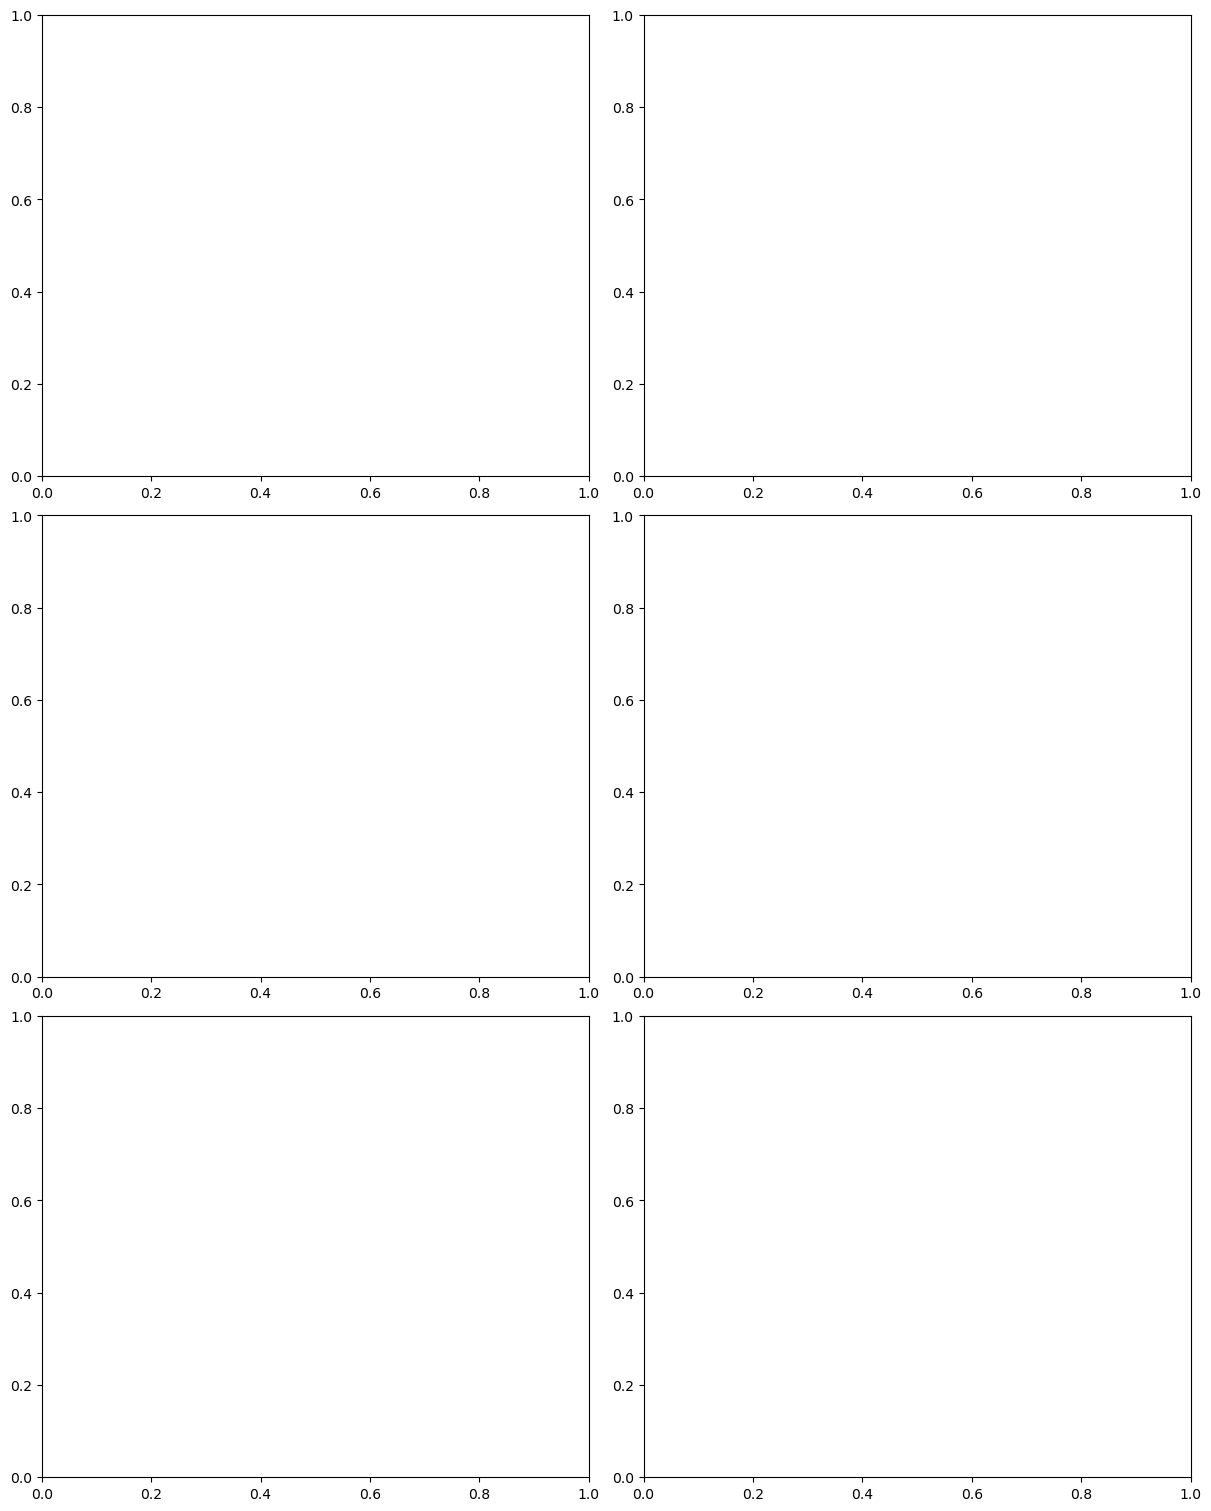

In [29]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# Extract variables
tauu_LL = ds_models_tauu[0].tauuo
tauv_LL = ds_models_tauv[0].tauvo
tauu_HH = ds_models_tauu[1].tauuo
tauv_HH = ds_models_tauv[1].tauvo

# Extract the correct coordinate names ('i', 'j') instead of ('latitude', 'longitude')
lat_LL, lon_LL = tauu_LL['latitude'], tauu_LL['longitude']
lat_HH, lon_HH = tauu_HH['latitude'], tauu_HH['longitude']

# Align dimensions to ('i', 'j')
tauv_LL = tauv_LL.isel(i=slice(0, tauu_LL.sizes['i']), j=slice(0, tauu_LL.sizes['j']))
tauv_HH = tauv_HH.isel(i=slice(0, tauu_HH.sizes['i']), j=slice(0, tauu_HH.sizes['j']))

# Compute derived variables
tau_magnitude_LL = np.sqrt(tauu_LL**2 + tauv_LL**2)
tau_magnitude_HH = np.sqrt(tauu_HH**2 + tauv_HH**2)
tau_magnitude_diff = tau_magnitude_LL - tau_magnitude_HH

# Ensure shapes match for quiver plotting
tauu_LL = tauu_LL.broadcast_like(tauv_LL)
tauu_HH = tauu_HH.broadcast_like(tauv_HH)

# Create figure (3 rows, 2 columns)
fig, axes = plt.subplots(3, 2, figsize=(12, 15), constrained_layout=True)

# Titles
titles = [
    "Wind Stress Vectors - LL", "Wind Stress Vectors - HH",
    "Difference (LL - HH)", "Magnitude - LL",
    "Magnitude - HH", "Magnitude Difference"
]

# Plot vectors (row 1)
q1 = axes[0, 0].quiver(lon_LL, lat_LL, tauu_LL, tauv_LL, scale=10)
axes[0, 0].set_title(titles[0])

q2 = axes[0, 1].quiver(lon_HH, lat_HH, tauu_HH, tauv_HH, scale=10)
axes[0, 1].set_title(titles[1])

# Plot vector difference (row 2)
q3 = axes[1, 0].quiver(lon_LL, lat_LL, tauu_LL - tauu_HH, tauv_LL - tauv_HH, scale=10)
axes[1, 0].set_title(titles[2])

# Plot magnitude (row 3)
c1 = axes[1, 1].contourf(lon_LL, lat_LL, tau_magnitude_LL, cmap="plasma")
fig.colorbar(c1, ax=axes[1, 1])
axes[1, 1].set_title(titles[3])

c2 = axes[2, 0].contourf(lon_HH, lat_HH, tau_magnitude_HH, cmap="plasma")
fig.colorbar(c2, ax=axes[2, 0])
axes[2, 0].set_title(titles[4])

c3 = axes[2, 1].contourf(lon_LL, lat_LL, tau_magnitude_diff, cmap="RdBu_r")
fig.colorbar(c3, ax=axes[2, 1])
axes[2, 1].set_title(titles[5])

# Show figure
plt.show()


In [32]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# Extract variables
tauu_LL = ds_models_tauu[0].tauuo
tauv_LL = ds_models_tauv[0].tauvo
tauu_HH = ds_models_tauu[1].tauuo
tauv_HH = ds_models_tauv[1].tauvo

# Extract coordinates
lat_LL, lon_LL = tauu_LL['latitude'], tauu_LL['longitude']
lat_HH, lon_HH = tauu_HH['latitude'], tauu_HH['longitude']

# Compute wind stress magnitude
tau_magnitude_LL = np.sqrt(tauu_LL**2 + tauv_LL**2)
tau_magnitude_HH = np.sqrt(tauu_HH**2 + tauv_HH**2)
tau_magnitude_diff = tau_magnitude_LL - tau_magnitude_HH

# Ensure coordinate dimensions match pcolormesh requirements
lon_LL, lat_LL = np.meshgrid(lon_LL, lat_LL)
lon_HH, lat_HH = np.meshgrid(lon_HH, lat_HH)

# Create figure (1 row, 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)

# Titles
titles = ["Wind Stress Magnitude - LL", "Wind Stress Magnitude - HH", "Magnitude Difference"]

# Plot magnitude for LL using pcolormesh
c1 = axes[0].pcolormesh(lon_LL, lat_LL, tau_magnitude_LL, cmap="plasma", shading="auto")
fig.colorbar(c1, ax=axes[0])
axes[0].set_title(titles[0])

# Plot magnitude for HH using pcolormesh
c2 = axes[1].pcolormesh(lon_HH, lat_HH, tau_magnitude_HH, cmap="plasma", shading="auto")
fig.colorbar(c2, ax=axes[1])
axes[1].set_title(titles[1])

# Plot magnitude difference (LL - HH) using pcolormesh
c3 = axes[2].pcolormesh(lon_LL, lat_LL, tau_magnitude_diff, cmap="RdBu_r", shading="auto")
fig.colorbar(c3, ax=axes[2])
axes[2].set_title(titles[2])

# Show figure
plt.show()


MemoryError: Unable to allocate 21.5 TiB for an array with shape (1719720, 1719720) and data type float64